# 模型打分與反事實一致性評測

本 Notebook 以兩個模型（Baseline 與 Fair）對資料集進行打分，輸出打分檔，並在反事實配對集上計算分數位移與決策翻轉率：
- 資料1：`pairs_longtext.csv`（主評測集）→ 產生 `baseline_scored.csv` 與 `fair_scored.csv`。
- 資料2：`counterfactual_pairs_longtext.csv`（反事實配對集）→ 產生 `counterfactual_scored.csv`，並計算位移與翻轉率（預設錄取率 r=10%）。

打分邏輯沿用 Inference Demo：
- 取最後隱層輸出做 mean pooling。
- L2 normalize 後用點積作為 cosine 相似度（raw_cosine）。
- 以 sigmoid(cosine) 當作機率分數（prob）。

In [4]:
# 1) Imports & basic setup
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

# Try optional peft import; fall back gracefully if missing
try:
    from peft import PeftModel  # type: ignore
except Exception:
    PeftModel = None
    print("peft not installed; remote LoRA adapter loading will be skipped. Install with `pip install peft`.")

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
BASE_MODEL = 'BAAI/bge-large-en-v1.5'
DATA_DIR = Path('..') / 'data' / 'eval'
OUT_BASELINE = DATA_DIR / 'baseline_scored.csv'
OUT_FAIR = DATA_DIR / 'fair_scored.csv'
OUT_CF = DATA_DIR / 'counterfactual_scored.csv'
OUT_ALL = DATA_DIR / 'all_models_scored.csv'  # unified output
print(f'Device: {DEVICE}')
print(f'Data dir: {DATA_DIR.resolve()}')

# 1.1 Configurable parameters (adjust here)
R_ACCEPT = 0.10      # acceptance rate for parity & flip metrics
TOP_K = 10           # Top-K for exposure
BATCH_BGE = 32       # batch size for BGE-based models
BATCH_JOBBERT = 8    # batch size for JobBERT
MAX_LEN_BGE = 256    # max length for BGE tokenizer
print(f'Config => R_ACCEPT={R_ACCEPT}, TOP_K={TOP_K}, BATCH_BGE={BATCH_BGE}, BATCH_JOBBERT={BATCH_JOBBERT}')

/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Device: mps
Data dir: /Users/edwardhuang/Documents/GitHub/bge-lora-fairness-finetuning/data/eval
Config => R_ACCEPT=0.1, TOP_K=10, BATCH_BGE=32, BATCH_JOBBERT=8


In [5]:
# 2) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.model_max_length = 256
print('Tokenizer loaded.')

Tokenizer loaded.


## 載入兩個模型
- Baseline：Hugging Face 上的 LoRA adapter `shashu2325/resume-job-matcher-lora`（若無 peft 或下載失敗則退回 base）。
- Fair：本地 `models/fair_adversarial/best_fairness_model.pt` 權重（若不存在則使用 base 權重）。

In [6]:
# 3) Build Baseline model (base + remote LoRA if available)
REMOTE_ADAPTER_PATH = 'shashu2325/resume-job-matcher-lora'
base_model_for_baseline = AutoModel.from_pretrained(BASE_MODEL, torch_dtype=torch.float32)
if PeftModel is not None:
    try:
        baseline_model = PeftModel.from_pretrained(base_model_for_baseline, REMOTE_ADAPTER_PATH)
        print(f"Loaded remote LoRA adapter for baseline: {REMOTE_ADAPTER_PATH}")
    except Exception as e:
        print(f"Failed to load remote adapter: {e}; using base model as baseline.")
        baseline_model = base_model_for_baseline
else:
    print('peft not available; using base model as baseline.')
    baseline_model = base_model_for_baseline

baseline_model.to(DEVICE)
baseline_model.eval()
print('Baseline model ready.')

`torch_dtype` is deprecated! Use `dtype` instead!
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Loaded remote LoRA adapter for baseline: shashu2325/resume-job-matcher-lora
Loaded remote LoRA adapter for baseline: shashu2325/resume-job-matcher-lora
Baseline model ready.
Baseline model ready.


In [7]:
# 4) Build Fair model (load local checkpoint if available)
LOCAL_FAIR_CKPT = Path('..') / 'models' / 'fair_adversarial' / 'best_fairness_model.pt'
fair_model = AutoModel.from_pretrained(BASE_MODEL, torch_dtype=torch.float32)
if LOCAL_FAIR_CKPT.exists():
    try:
        ckpt = torch.load(LOCAL_FAIR_CKPT, map_location=DEVICE)
        state = ckpt.get('model_state_dict', None) if isinstance(ckpt, dict) else None
        if state is None and isinstance(ckpt, dict):
            state = ckpt
        if state is not None:
            missing, unexpected = fair_model.load_state_dict(state, strict=False)
            print(f"Loaded local fair checkpoint: {LOCAL_FAIR_CKPT}")
            print('  Missing keys:', len(missing), '| Unexpected keys:', len(unexpected))
        else:
            print('Checkpoint found but no model_state_dict; skipped loading.')
    except Exception as e:
        print(f"Failed to load local fair checkpoint: {e}; using base model weights.")
else:
    print('Local fair checkpoint not found; using base model weights.')

fair_model.to(DEVICE)
fair_model.eval()
print('Fair model ready.')

# 4.1 Load JobBERT (SentenceTransformer)
try:
    from sentence_transformers import SentenceTransformer, util as st_util
    jobbert_model = SentenceTransformer('TechWolf/JobBERT-v2')
    print('JobBERT model loaded.')
except Exception as e:
    jobbert_model = None
    print(f'Failed to load JobBERT: {e}')

Loaded local fair checkpoint: ../models/fair_adversarial/best_fairness_model.pt
  Missing keys: 391 | Unexpected keys: 715
Fair model ready.
Fair model ready.
JobBERT model loaded.
JobBERT model loaded.


## Encode 與打分輔助函數
提供批次處理，避免逐列呼叫過慢。

In [8]:
def encode_texts(texts, model, max_length=MAX_LEN_BGE, batch_size=BATCH_BGE):
    """Return L2-normalized embeddings (on CPU) for a list of texts using BGE-style model.
    texts: List[str]
    returns: torch.FloatTensor [N, dim] on CPU
    """
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            hidden = out.last_hidden_state  # (b, t, d)
            emb = hidden.mean(dim=1)
            emb = F.normalize(emb, p=2, dim=1)
        embs.append(emb.cpu())
    return torch.cat(embs, dim=0) if embs else torch.empty(0)

def match_scores(texts_a, texts_b, model, batch_size=BATCH_BGE):
    """Compute prob (sigmoid of cosine) and raw cosine for aligned pairs using BGE-style encoder."""
    assert len(texts_a) == len(texts_b), 'Pair lists must have same length'
    emb_a = encode_texts(texts_a, model, batch_size=batch_size)
    emb_b = encode_texts(texts_b, model, batch_size=batch_size)
    if len(emb_a) == 0:
        return np.array([]), np.array([])
    cos = torch.sum(emb_a * emb_b, dim=1)
    prob = torch.sigmoid(cos)
    return prob.numpy(), cos.numpy()

# JobBERT helpers
def encode_jobbert(texts, batch_size=BATCH_JOBBERT):
    """Return L2-normalized embeddings (numpy) for texts using JobBERT SentenceTransformer."""
    if jobbert_model is None or not texts:
        return np.empty((0,))
    # Sort by length for efficiency
    sorted_idx = np.argsort([len(t) for t in texts])
    sorted_texts = [texts[i] for i in sorted_idx]
    embs = []
    for i in range(0, len(sorted_texts), batch_size):
        batch = sorted_texts[i:i+batch_size]
        with torch.no_grad():
            emb = jobbert_model.encode(batch, convert_to_numpy=True, normalize_embeddings=True)
        embs.append(emb)
    embs = np.concatenate(embs, axis=0) if embs else np.empty((0,))
    # Reorder to original
    original_order = np.argsort(sorted_idx)
    embs = embs[original_order]
    return embs

def match_scores_jobbert(texts_a, texts_b, batch_size=BATCH_JOBBERT):
    """Compute prob (sigmoid of cosine) and raw cosine for aligned pairs using JobBERT."""
    assert len(texts_a) == len(texts_b), 'Pair lists must have same length'
    emb_a = encode_jobbert(texts_a, batch_size=batch_size)
    emb_b = encode_jobbert(texts_b, batch_size=batch_size)
    if emb_a.size == 0:
        return np.array([]), np.array([])
    # Cosine via dot product (already normalized)
    cos = (emb_a * emb_b).sum(axis=1)
    prob = 1/(1+np.exp(-cos))  # sigmoid
    return prob, cos

print('Helpers ready (BGE + JobBERT).')

Helpers ready (BGE + JobBERT).


## 主評測集：`pairs_longtext.csv` 打分並輸出兩個檔
- baseline_scored.csv：原欄位 + baseline_prob, baseline_raw_cosine
- fair_scored.csv：原欄位 + fair_prob, fair_raw_cosine

In [9]:
pairs_path = DATA_DIR / 'pairs_longtext.csv'
assert pairs_path.exists(), f'File not found: {pairs_path}'
df_pairs = pd.read_csv(pairs_path)
# Basic sanitation
for col in ['resume_text', 'job_text']:
    if col in df_pairs:
        df_pairs[col] = df_pairs[col].fillna('')

# Baseline scoring
b_prob, b_cos = match_scores(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), baseline_model, batch_size=BATCH_BGE)
# Fair scoring
f_prob, f_cos = match_scores(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), fair_model, batch_size=BATCH_BGE)
# JobBERT scoring
if jobbert_model is not None:
    jb_prob, jb_cos = match_scores_jobbert(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), batch_size=BATCH_JOBBERT)
else:
    jb_prob, jb_cos = np.zeros(len(df_pairs)), np.zeros(len(df_pairs))
    print('JobBERT unavailable; filled zeros.')

# Unified DataFrame
df_all = df_pairs.copy()
df_all['baseline_prob'] = b_prob
df_all['baseline_raw_cosine'] = b_cos
df_all['fair_prob'] = f_prob
df_all['fair_raw_cosine'] = f_cos
df_all['bert_prob'] = jb_prob
df_all['bert_raw_cosine'] = jb_cos
df_all.to_csv(OUT_ALL, index=False)
print(f'Wrote unified scores: {OUT_ALL}')

# (Optionally keep legacy separate outputs if needed)
# df_base = df_pairs.copy(); df_base['baseline_prob']=b_prob; df_base['baseline_raw_cosine']=b_cos; df_base.to_csv(OUT_BASELINE, index=False)
# df_fair = df_pairs.copy(); df_fair['fair_prob']=f_prob; df_fair['fair_raw_cosine']=f_cos; df_fair.to_csv(OUT_FAIR, index=False)
# For downstream cells expecting df_base/df_fair keep in-memory copies:
df_base = df_all[['resume_text','job_text','baseline_prob','baseline_raw_cosine']].copy()
df_fair = df_all[['resume_text','job_text','fair_prob','fair_raw_cosine']].copy()
print('Prepared df_base & df_fair views from unified frame.')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wrote unified scores: ../data/eval/all_models_scored.csv
Prepared df_base & df_fair views from unified frame.


## 反事實配對集：`counterfactual_pairs_longtext.csv` 打分與一致性評測
輸出：`counterfactual_scored.csv` 加上四欄（base_prob_orig, base_prob_cf, fair_prob_orig, fair_prob_cf）。
同時計算：
- 位移（abs(prob_orig - prob_cf)）的平均與 P95。
- 決策翻轉率：固定錄取率 r（預設 10%），以原分佈設定門檻，觀察 orig 與 cf 是否翻轉。

In [10]:
cf_path = DATA_DIR / 'counterfactual_pairs_longtext.csv'
assert cf_path.exists(), f'File not found: {cf_path}'
df_cf = pd.read_csv(cf_path)
for col in ['resume_text_orig', 'resume_text_cf', 'job_text']:
    if col in df_cf:
        df_cf[col] = df_cf[col].fillna('')

# Baseline scores for orig/cf
b_prob_orig, _ = match_scores(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), baseline_model, batch_size=BATCH_BGE)
b_prob_cf, _   = match_scores(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), baseline_model, batch_size=BATCH_BGE)
# Fair scores for orig/cf
f_prob_orig, _ = match_scores(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), fair_model, batch_size=BATCH_BGE)
f_prob_cf, _   = match_scores(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), fair_model, batch_size=BATCH_BGE)
# JobBERT scores for orig/cf
if jobbert_model is not None:
    jb_prob_orig, _ = match_scores_jobbert(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), batch_size=BATCH_JOBBERT)
    jb_prob_cf, _   = match_scores_jobbert(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), batch_size=BATCH_JOBBERT)
else:
    jb_prob_orig = np.zeros(len(df_cf)); jb_prob_cf = np.zeros(len(df_cf))
    print('JobBERT unavailable for counterfactual; zeros used.')

df_cf_scored = df_cf.copy()
df_cf_scored['base_prob_orig'] = b_prob_orig
df_cf_scored['base_prob_cf']   = b_prob_cf
df_cf_scored['fair_prob_orig'] = f_prob_orig
df_cf_scored['fair_prob_cf']   = f_prob_cf
df_cf_scored['bert_prob_orig'] = jb_prob_orig
df_cf_scored['bert_prob_cf']   = jb_prob_cf
df_cf_scored.to_csv(OUT_CF, index=False)
print(f'Wrote {OUT_CF}')

def summarize_counterfactual(prob_orig, prob_cf, r=R_ACCEPT, label='model'):
    prob_orig = np.asarray(prob_orig)
    prob_cf   = np.asarray(prob_cf)
    abs_shift = np.abs(prob_orig - prob_cf)
    mean_shift = float(abs_shift.mean()) if len(abs_shift) else 0.0
    p95_shift  = float(np.quantile(abs_shift, 0.95)) if len(abs_shift) else 0.0
    thr = float(np.quantile(prob_orig, 1.0 - r)) if len(prob_orig) else 1.0
    dec_orig = (prob_orig >= thr)
    dec_cf   = (prob_cf   >= thr)
    flip_rate = float((dec_orig != dec_cf).mean()) if len(prob_orig) else 0.0
    print(f"[{label}] r={r*100:.0f}% | mean_shift={mean_shift:.4f} | p95_shift={p95_shift:.4f} | flip_rate={flip_rate:.4f} | thr={thr:.4f}")
    return {'r': r, 'mean_shift': mean_shift, 'p95_shift': p95_shift, 'flip_rate': flip_rate, 'threshold': thr}

summary_baseline = summarize_counterfactual(b_prob_orig, b_prob_cf, label='baseline')
summary_fair     = summarize_counterfactual(f_prob_orig, f_prob_cf, label='fair')
summary_bert     = summarize_counterfactual(jb_prob_orig, jb_prob_cf, label='bert')

with open(DATA_DIR / 'counterfactual_summary.json', 'w') as f:
    json.dump({'baseline': summary_baseline, 'fair': summary_fair, 'bert': summary_bert}, f, indent=2)
print('Saved counterfactual_summary.json (baseline, fair, bert)')

Wrote ../data/eval/counterfactual_scored.csv
[baseline] r=10% | mean_shift=0.0159 | p95_shift=0.0412 | flip_rate=0.1667 | thr=0.6809
[fair] r=10% | mean_shift=0.0057 | p95_shift=0.0136 | flip_rate=0.1552 | thr=0.6932
[bert] r=10% | mean_shift=0.0079 | p95_shift=0.0258 | flip_rate=0.1427 | thr=0.7106
Saved counterfactual_summary.json (baseline, fair, bert)


## 群體與個體公平分析（進一步）

以下使用本 Notebook 生成的分數直接計算：
- 群體公平（Demographic Parity, DP）在固定錄取率 r 下的 selection rate 差異。
- Top-K / 曝光：每個 job 的前 K 名群體比例與曝光份額。
- 個體公平（Local Consistency）：對同職位、相似履歷的分數差異。

In [11]:
# 7) 群體公平（DP）在固定錄取率 r 下的 selection rate 差異
import numpy as np
import pandas as pd

def selection_rate_parity(df: pd.DataFrame, prob_col: str, group_col: str, r: float = R_ACCEPT):
    df = df.copy()
    if prob_col not in df or group_col not in df:
        return None
    thr = float(np.quantile(df[prob_col].values, 1.0 - r))
    df['selected'] = df[prob_col] >= thr
    rates = df.groupby(group_col)['selected'].mean().to_dict()
    if len(rates) >= 2:
        dp_diff = float(max(rates.values()) - min(rates.values()))
    else:
        dp_diff = 0.0
    return {'threshold': thr, 'selection_rates': {str(k): float(v) for k, v in rates.items()}, 'dp_diff': dp_diff}

print(f'Using R_ACCEPT={R_ACCEPT} for DP metrics.')

# Iterate over models and groups
model_frames = {
    'baseline': ('baseline_prob', df_all),
    'fair': ('fair_prob', df_all),
    'bert': ('bert_prob', df_all)
}
for group_col in ['is_top_school', 'school_category']:
   for m_name, (pcol, frame) in model_frames.items():
        if group_col in frame.columns and pcol in frame.columns:
            res = selection_rate_parity(frame, pcol, group_col)
            print(f'[{m_name}][DP] {group_col}:', res)

Using R_ACCEPT=0.1 for DP metrics.
[baseline][DP] is_top_school: {'threshold': 0.6808725655078888, 'selection_rates': {'0': 0.10140405616224649, '1': 0.09717868338557993}, 'dp_diff': 0.0042253727766665555}
[fair][DP] is_top_school: {'threshold': 0.6932081282138824, 'selection_rates': {'0': 0.1029641185647426, '1': 0.09404388714733543}, 'dp_diff': 0.008920231417407165}
[bert][DP] is_top_school: {'threshold': 0.7106265604496003, 'selection_rates': {'0': 0.0998439937597504, '1': 0.10031347962382445}, 'dp_diff': 0.000469485864074054}
[baseline][DP] school_category: {'threshold': 0.6808725655078888, 'selection_rates': {'A': 0.09717868338557993, 'B': 0.14473684210526316, 'C': 0.0804953560371517, 'D': 0.10240963855421686}, 'dp_diff': 0.06424148606811146}
[fair][DP] school_category: {'threshold': 0.6932081282138824, 'selection_rates': {'A': 0.09404388714733543, 'B': 0.13157894736842105, 'C': 0.10835913312693499, 'D': 0.06626506024096386}, 'dp_diff': 0.06531388712745718}
[bert][DP] school_categ

In [12]:
# 8) Top-K 與曝光：每個 job 的前 K 名群體比例與曝光份額
import numpy as np
import pandas as pd

print(f'Using TOP_K={TOP_K} for exposure metrics.')

def topk_exposure(df: pd.DataFrame, prob_col: str, group_col: str, job_col: str = 'job_id', K: int = TOP_K):
    if not all(c in df.columns for c in [prob_col, group_col, job_col]):
        return None
    counts = {}
    exposure = {}
    total_in_topk = 0
    total_expo = 0.0
    for job, g in df.groupby(job_col):
        g_sorted = g.sort_values(prob_col, ascending=False).head(K)
        total_in_topk += len(g_sorted)
        for idx, (_, row) in enumerate(g_sorted.iterrows()):
            grp = row[group_col]
            counts[grp] = counts.get(grp, 0) + 1
            w = 1.0/np.log2(idx+2+1e-9)
            exposure[grp] = exposure.get(grp, 0.0) + w
            total_expo += w
    frac = {str(k): (v/total_in_topk if total_in_topk>0 else 0.0) for k, v in counts.items()}
    expo_share = {str(k): (v/total_expo if total_expo>0 else 0.0) for k, v in exposure.items()}
    return {'K': K,'topk_fraction_by_group': frac,'exposure_share_by_group': expo_share,'total_topk': int(total_in_topk)}

model_frames = {
    'baseline': ('baseline_prob', df_all),
    'fair': ('fair_prob', df_all),
    'bert': ('bert_prob', df_all)
}
for group_col in ['is_top_school', 'school_category']:
    for m_name, (pcol, frame) in model_frames.items():
        if 'job_id' in frame.columns and group_col in frame.columns and pcol in frame.columns:
            res = topk_exposure(frame, pcol, group_col, job_col='job_id', K=TOP_K)
            print(f'[{m_name}][TopK/Exposure] {group_col}:', res)

Using TOP_K=10 for exposure metrics.
[baseline][TopK/Exposure] is_top_school: {'K': 10, 'topk_fraction_by_group': {'0': 0.6416666666666667, '1': 0.35833333333333334}, 'exposure_share_by_group': {'0': 0.674132499464133, '1': 0.3258675005358673}, 'total_topk': 120}
[fair][TopK/Exposure] is_top_school: {'K': 10, 'topk_fraction_by_group': {'1': 0.3, '0': 0.7}, 'exposure_share_by_group': {'1': 0.27078886756016146, '0': 0.7292111324398387}, 'total_topk': 120}
[bert][TopK/Exposure] is_top_school: {'K': 10, 'topk_fraction_by_group': {'1': 0.35, '0': 0.65}, 'exposure_share_by_group': {'1': 0.3545186344493886, '0': 0.6454813655506119}, 'total_topk': 120}
[baseline][TopK/Exposure] school_category: {'K': 10, 'topk_fraction_by_group': {'C': 0.2833333333333333, 'B': 0.175, 'D': 0.18333333333333332, 'A': 0.35833333333333334}, 'exposure_share_by_group': {'C': 0.2866040931345047, 'B': 0.16296036011327353, 'D': 0.2245680462163544, 'A': 0.3258675005358673}, 'total_topk': 120}
[fair][TopK/Exposure] school

In [13]:
# 9) 個體公平（Local Consistency）：同職位相似履歷的分數差異
import numpy as np
from sklearn.neighbors import NearestNeighbors

N_NEIGHBORS = 5       # 每個樣本的相似履歷數
SAMPLE_CAP_PER_JOB = 500  # 每個 job 取樣上限

def local_consistency_for_job(df_job, prob_cols, text_col='resume_text'):
    df_j = df_job.copy()
    if len(df_j) > SAMPLE_CAP_PER_JOB:
        df_j = df_j.sample(SAMPLE_CAP_PER_JOB, random_state=42).reset_index(drop=True)
    texts = df_j[text_col].fillna('').tolist()
    emb = encode_texts(texts, baseline_model, batch_size=64)  # baseline embedding space
    if emb.shape[0] <= 1:
        return {pc: {'mean': 0.0, 'p95': 0.0} for pc in prob_cols}
    nn = NearestNeighbors(n_neighbors=min(N_NEIGHBORS+1, emb.shape[0]), metric='cosine')
    nn.fit(emb.numpy())
    distances, indices = nn.kneighbors(emb.numpy())
    neighbor_indices = [idxs[1:] if len(idxs) > 1 else idxs for idxs in indices]
    out = {}
    for pc in prob_cols:
        if pc not in df_j.columns:
            out[pc] = {'mean': 0.0, 'p95': 0.0}
            continue
        scores = df_j[pc].values.astype(float)
        deltas = []
        for i, nbrs in enumerate(neighbor_indices):
            for j in nbrs:
                deltas.append(abs(scores[i] - scores[j]))
        if len(deltas) == 0:
            out[pc] = {'mean': 0.0, 'p95': 0.0}
        else:
            deltas = np.asarray(deltas)
            out[pc] = {'mean': float(deltas.mean()),'p95': float(np.quantile(deltas, 0.95))}
    return out

def local_consistency_overall(df_pairs_scored):
    if 'job_id' not in df_pairs_scored.columns:
        print('job_id not found; skip local consistency')
        return None
    results = []
    for job, g in df_pairs_scored.groupby('job_id'):
        res = local_consistency_for_job(g, prob_cols=['baseline_prob','fair_prob','bert_prob'])
        results.append({'job_id': job, **{f"{k}_{m}": v[m] for k, v in res.items() for m in ['mean','p95']}})
    if not results:
        return None
    df_res = pd.DataFrame(results)
    summary = {
        'baseline_mean_mean': float(df_res['baseline_prob_mean'].mean()),
        'baseline_mean_p95': float(df_res['baseline_prob_p95'].mean()),
        'fair_mean_mean': float(df_res['fair_prob_mean'].mean()),
        'fair_mean_p95': float(df_res['fair_prob_p95'].mean()),
        'bert_mean_mean': float(df_res['bert_prob_mean'].mean()),
        'bert_mean_p95': float(df_res['bert_prob_p95'].mean()),
    }
    return {'per_job': df_res, 'summary': summary}

df_pairs_scored = df_all[['job_id','resume_text','baseline_prob','fair_prob','bert_prob']].copy()
lc = local_consistency_overall(df_pairs_scored)
if lc is not None:
    print('[Local Consistency][Summary]:', lc['summary'])

[Local Consistency][Summary]: {'baseline_mean_mean': 0.009084734084705512, 'baseline_mean_p95': 0.022078687449296308, 'fair_mean_mean': 0.004569848328828812, 'fair_mean_p95': 0.011678169667720785, 'bert_mean_mean': 0.007304486110806464, 'bert_mean_p95': 0.02143320093552271}


## Visualizations (English)

This section renders visual summaries:
- Overall score distributions (baseline vs fair)
- Demographic Parity (selection rates by group) side-by-side
- Top-K fraction and Exposure share by group per job
- Counterfactual shifts (orig vs counterfactual) and flip rate
- Local consistency summary (average neighbor delta)

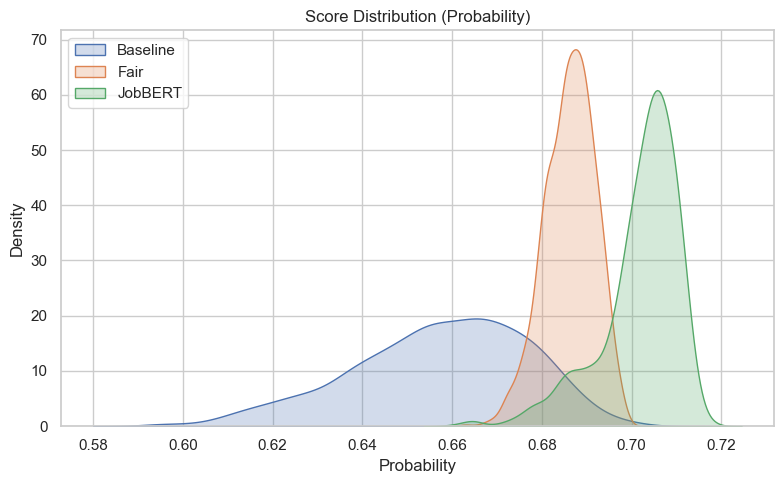

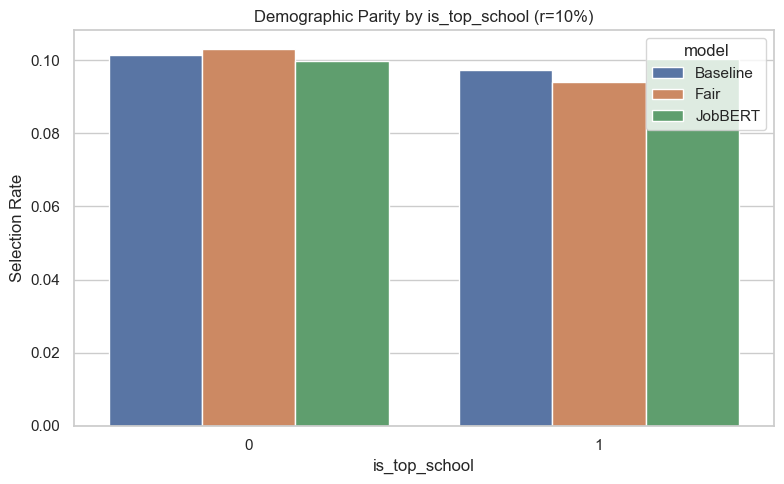

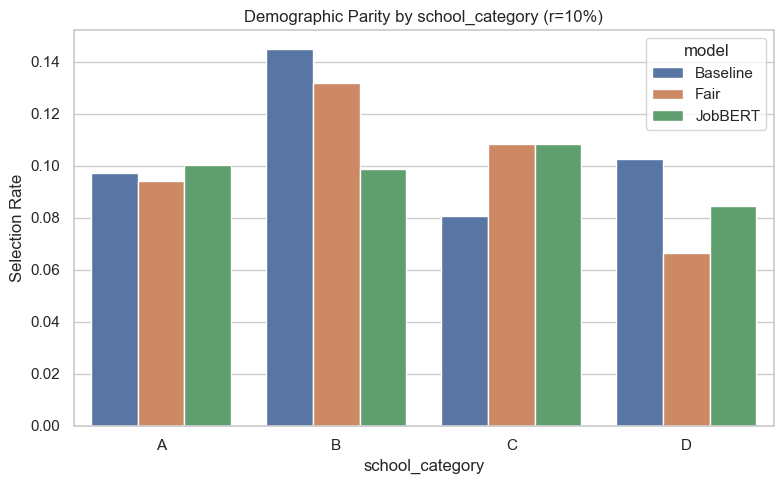

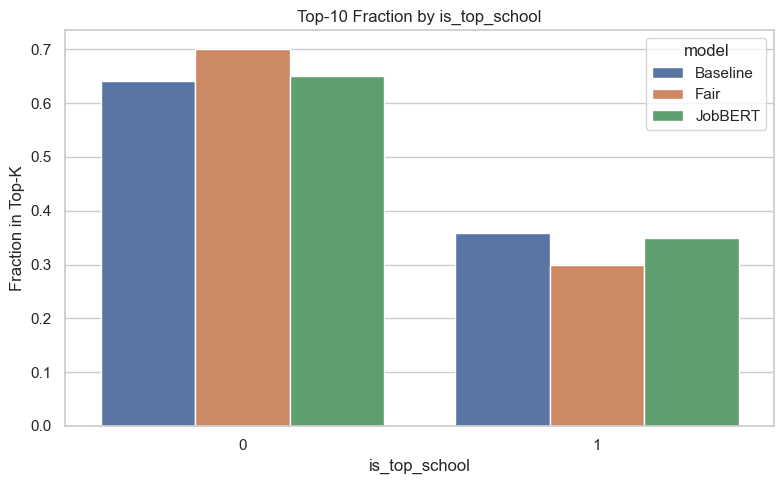

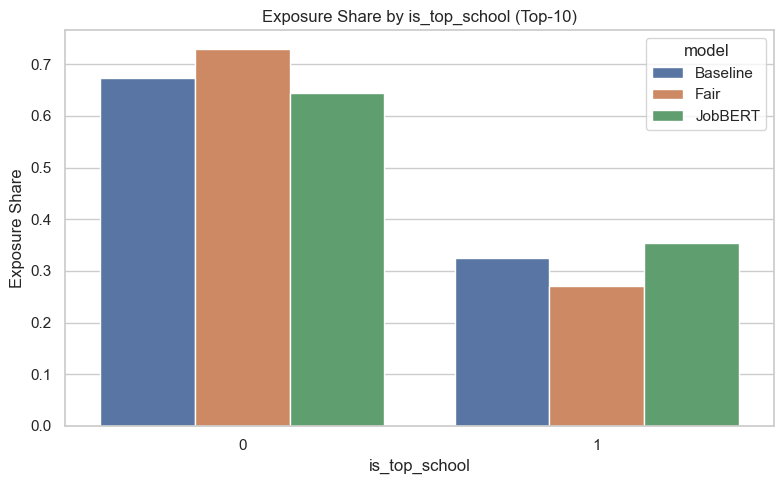

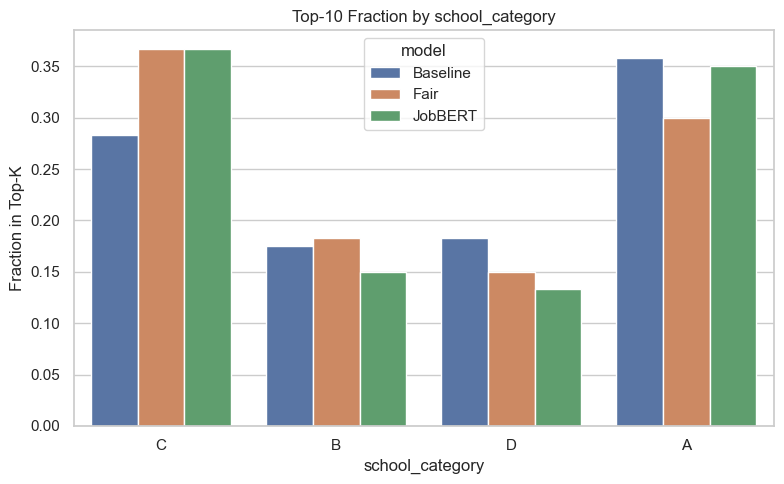

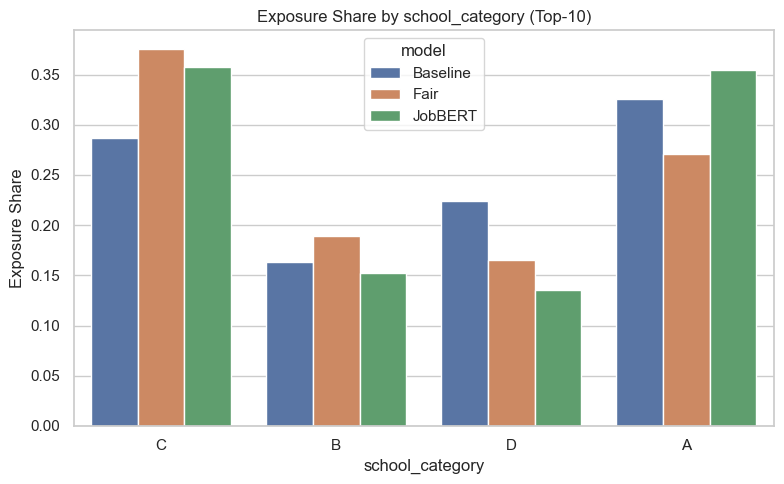

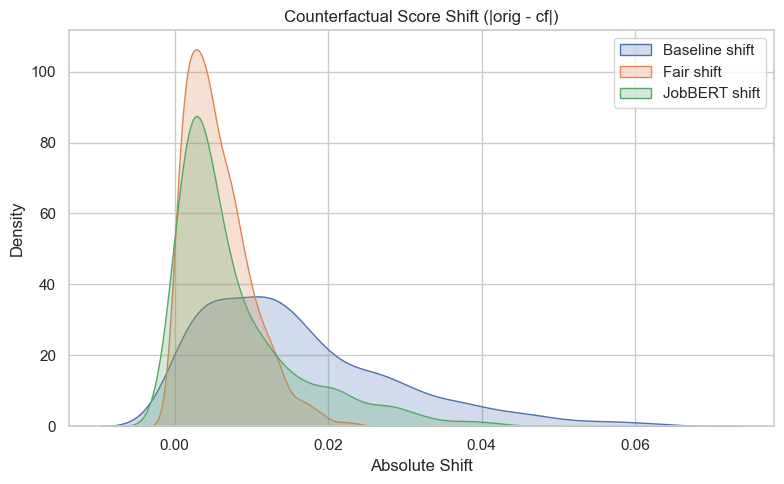

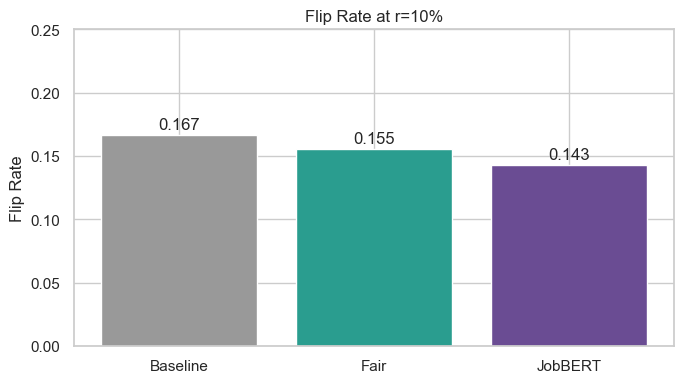

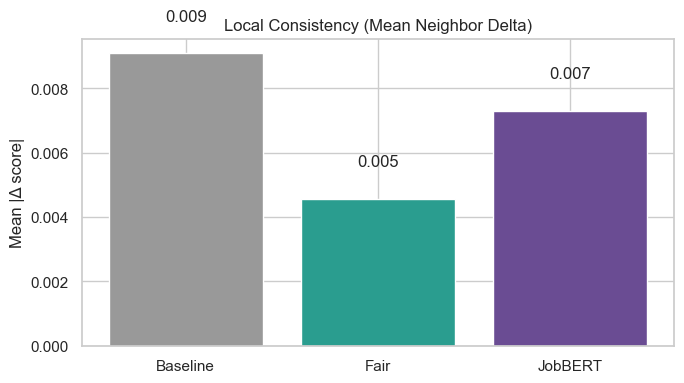

Visualization completed. Figures saved to: ../reports/fairness_metrics


In [14]:
# 10) Visualization Dashboard
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

SAVE_FIGS = True
FIG_DIR = Path('..') / 'reports' /  'fairness_metrics'
if SAVE_FIGS:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

R_ACCEPT = globals().get('R_ACCEPT', R_ACCEPT)
TOP_K = globals().get('TOP_K', TOP_K)

def selection_rate_parity(df: pd.DataFrame, prob_col: str, group_col: str, r: float = R_ACCEPT):
    d = df[[prob_col, group_col]].dropna().copy()
    if d.empty:
        return None
    thr = float(np.quantile(d[prob_col].values, 1.0 - r))
    d['selected'] = d[prob_col] >= thr
    rates = d.groupby(group_col)['selected'].mean().to_dict()
    dp_diff = float(max(rates.values()) - min(rates.values())) if len(rates) >= 2 else 0.0
    return {'threshold': thr, 'selection_rates': {str(k): float(v) for k, v in rates.items()}, 'dp_diff': dp_diff}

def topk_exposure(df: pd.DataFrame, prob_col: str, group_col: str, job_col: str = 'job_id', K: int = TOP_K):
    if not all(c in df.columns for c in [prob_col, group_col, job_col]):
        return None
    counts, exposure = {}, {}
    total_in_topk, total_expo = 0, 0.0
    for job, g in df.groupby(job_col):
        g_sorted = g.sort_values(prob_col, ascending=False).head(K)
        total_in_topk += len(g_sorted)
        for idx, (_, row) in enumerate(g_sorted.iterrows()):
            grp = row[group_col]
            counts[grp] = counts.get(grp, 0) + 1
            w = 1.0/np.log2(idx+2+1e-9)
            exposure[grp] = exposure.get(grp, 0.0) + w
            total_expo += w
    frac = {str(k): (v/total_in_topk if total_in_topk>0 else 0.0) for k, v in counts.items()}
    expo_share = {str(k): (v/total_expo if total_expo>0 else 0.0) for k, v in exposure.items()}
    return {'K': K, 'topk_fraction_by_group': frac, 'exposure_share_by_group': expo_share, 'total_topk': int(total_in_topk)}

# 10.1 Score distribution
try:
    fig, ax = plt.subplots(figsize=(8,5))
    if 'baseline_prob' in df_all.columns:
        sns.kdeplot(df_all['baseline_prob'], ax=ax, label='Baseline', fill=True, alpha=0.25)
    if 'fair_prob' in df_all.columns:
        sns.kdeplot(df_all['fair_prob'], ax=ax, label='Fair', fill=True, alpha=0.25)
    if 'bert_prob' in df_all.columns:
        sns.kdeplot(df_all['bert_prob'], ax=ax, label='JobBERT', fill=True, alpha=0.25)
    ax.set_title('Score Distribution (Probability)')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(FIG_DIR / 'score_distribution.png', dpi=200)
    plt.show()
except Exception as e:
    print('Score distribution plot skipped:', e)

# 10.2 Demographic Parity Bars
for group_col in ['is_top_school', 'school_category']:
    try:
        rows = []
        for model_name, pcol in [('Baseline','baseline_prob'),('Fair','fair_prob'),('JobBERT','bert_prob')]:
            if group_col in df_all.columns and pcol in df_all.columns:
                dp = selection_rate_parity(df_all, pcol, group_col, r=R_ACCEPT)
                if dp:
                    for g, v in dp['selection_rates'].items():
                        rows.append({'group': g, 'model': model_name, 'selection_rate': v})
        if rows:
            df_plot = pd.DataFrame(rows)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_plot, x='group', y='selection_rate', hue='model', ax=ax)
            ax.set_title(f'Demographic Parity by {group_col} (r={int(R_ACCEPT*100)}%)')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Selection Rate')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'dp_{group_col}.png', dpi=200)
            plt.show()
    except Exception as e:
        print(f'DP plot for {group_col} skipped:', e)

# 10.3 Top-K exposure / fraction
for group_col in ['is_top_school', 'school_category']:
    try:
        rows_frac, rows_expo = [], []
        for model_name, pcol in [('Baseline','baseline_prob'),('Fair','fair_prob'),('JobBERT','bert_prob')]:
            if all(c in df_all.columns for c in ['job_id', group_col, pcol]):
                t = topk_exposure(df_all, pcol, group_col, job_col='job_id', K=TOP_K)
                if t:
                    for g, v in t['topk_fraction_by_group'].items():
                        rows_frac.append({'group': g, 'model': model_name, 'fraction': v})
                    for g, v in t['exposure_share_by_group'].items():
                        rows_expo.append({'group': g, 'model': model_name, 'exposure': v})
        if rows_frac:
            df_frac = pd.DataFrame(rows_frac)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_frac, x='group', y='fraction', hue='model', ax=ax)
            ax.set_title(f'Top-{TOP_K} Fraction by {group_col}')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Fraction in Top-K')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'topk_fraction_{group_col}.png', dpi=200)
            plt.show()
        if rows_expo:
            df_expo = pd.DataFrame(rows_expo)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_expo, x='group', y='exposure', hue='model', ax=ax)
            ax.set_title(f'Exposure Share by {group_col} (Top-{TOP_K})')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Exposure Share')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'exposure_share_{group_col}.png', dpi=200)
            plt.show()
    except Exception as e:
        print(f'Top-K/Exposure plot for {group_col} skipped:', e)

# 10.4 Counterfactual shift & flip rate (extended for bert)
try:
    if 'df_cf_scored' in globals():
        b_po = df_cf_scored.get('base_prob_orig', np.array([]))
        b_pc = df_cf_scored.get('base_prob_cf',   np.array([]))
        f_po = df_cf_scored.get('fair_prob_orig', np.array([]))
        f_pc = df_cf_scored.get('fair_prob_cf',   np.array([]))
        jb_po = df_cf_scored.get('bert_prob_orig', np.array([]))
        jb_pc = df_cf_scored.get('bert_prob_cf',   np.array([]))
        shifts = []
        labels = []
        if len(b_po): shifts.append(np.abs(b_po-b_pc)); labels.append('Baseline shift')
        if len(f_po): shifts.append(np.abs(f_po-f_pc)); labels.append('Fair shift')
        if len(jb_po): shifts.append(np.abs(jb_po-jb_pc)); labels.append('JobBERT shift')
        if shifts:
            fig, ax = plt.subplots(figsize=(8,5))
            for arr, lab in zip(shifts, labels):
                sns.kdeplot(arr, ax=ax, label=lab, fill=True, alpha=0.25)
            ax.set_title('Counterfactual Score Shift (|orig - cf|)')
            ax.set_xlabel('Absolute Shift')
            ax.set_ylabel('Density')
            ax.legend()
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'counterfactual_shift.png', dpi=200)
            plt.show()
        def flip_rate(arr_o, arr_c, r=R_ACCEPT):
            if len(arr_o) == 0: return 0.0
            thr = float(np.quantile(arr_o, 1.0 - r))
            return float(((arr_o >= thr) != (arr_c >= thr)).mean())
        if len(b_po) and len(f_po) and len(jb_po):
            fr_b = flip_rate(b_po, b_pc)
            fr_f = flip_rate(f_po, f_pc)
            fr_j = flip_rate(jb_po, jb_pc)
            fig, ax = plt.subplots(figsize=(7,4))
            ax.bar(['Baseline','Fair','JobBERT'], [fr_b, fr_f, fr_j], color=['#999','#2a9d8f','#6a4c93'])
            ax.set_title(f'Flip Rate at r={int(R_ACCEPT*100)}%')
            ax.set_ylabel('Flip Rate')
            for i, v in enumerate([fr_b, fr_f, fr_j]):
                ax.text(i, v + 0.005, f'{v:.3f}', ha='center')
            plt.ylim(0, max(fr_b, fr_f, fr_j)*1.2 + 0.05)
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'flip_rate.png', dpi=200)
            plt.show()
except Exception as e:
    print('Counterfactual plots skipped:', e)

# 10.5 Local consistency summary bar
try:
    if 'lc' in globals() and lc and 'summary' in lc:
        s = lc['summary']
        fig, ax = plt.subplots(figsize=(7,4))
        ax.bar(['Baseline','Fair','JobBERT'], [s['baseline_mean_mean'], s['fair_mean_mean'], s['bert_mean_mean']], color=['#999','#2a9d8f','#6a4c93'])
        ax.set_title('Local Consistency (Mean Neighbor Delta)')
        ax.set_ylabel('Mean |Δ score|')
        for i, v in enumerate([s['baseline_mean_mean'], s['fair_mean_mean'], s['bert_mean_mean']]):
            ax.text(i, v + 0.001, f'{v:.3f}', ha='center')
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'local_consistency_mean.png', dpi=200)
        plt.show()
except Exception as e:
    print('Local consistency plot skipped:', e)

print('Visualization completed. Figures saved to:', FIG_DIR if SAVE_FIGS else 'not saved')

## Additional Visual Insights (English)

Extra plots to further compare models:
- Baseline vs Fair probability scatter with y=x reference
- Group-wise probability distributions (violin/box)
- Position-wise exposure curve across ranks (aggregated over jobs)
- Counterfactual orig vs cf scatter with y=x reference
- Distribution of Fair − Baseline probability differences

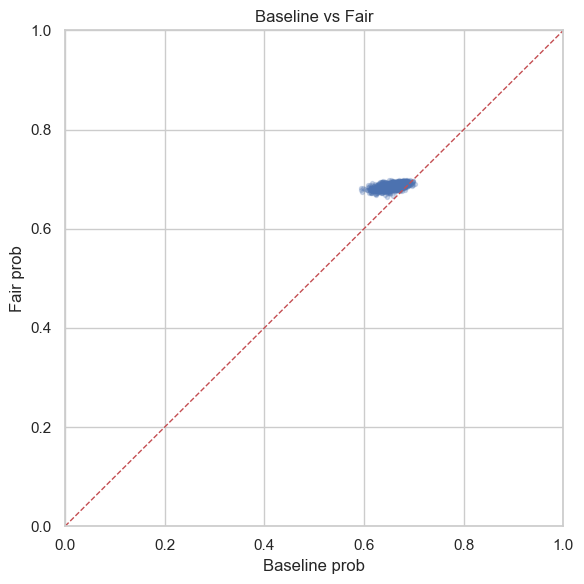

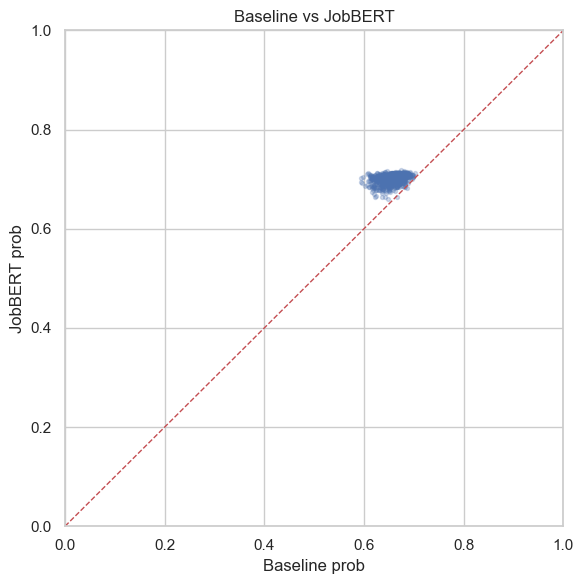

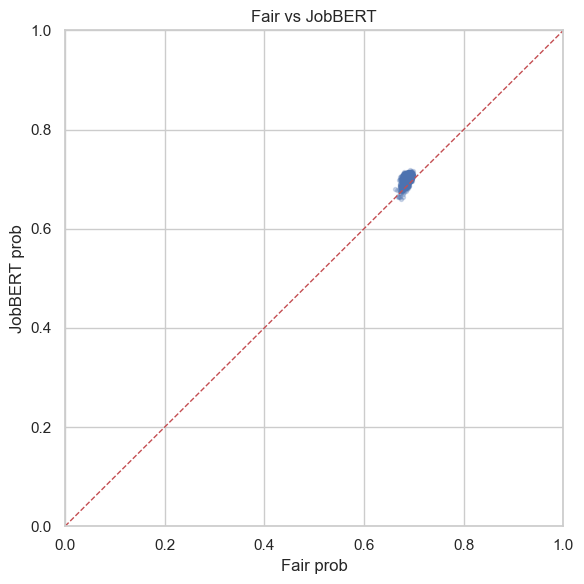

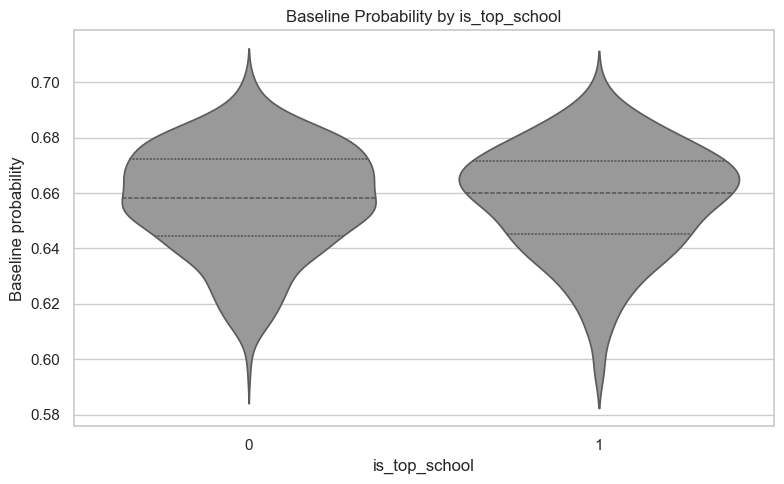

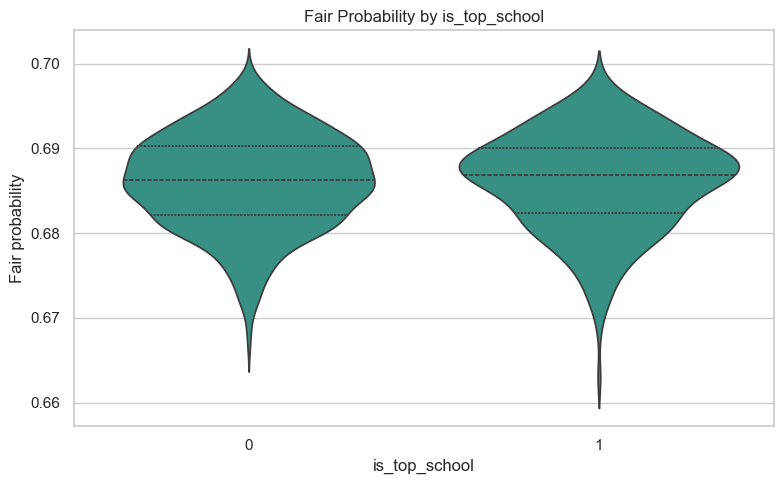

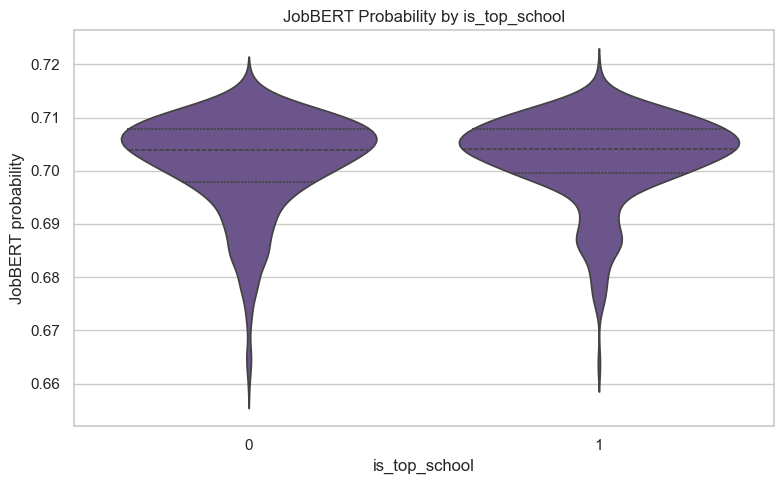

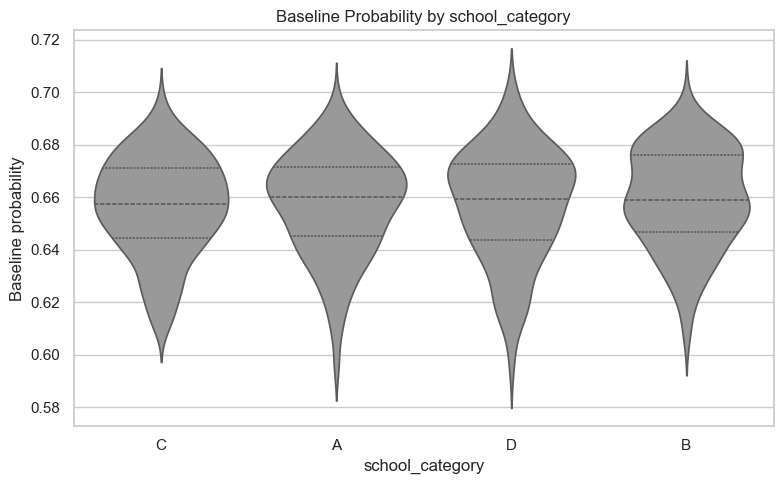

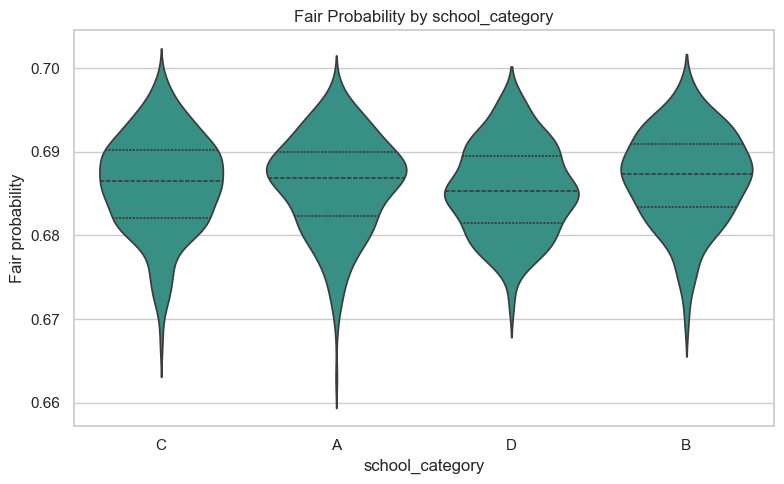

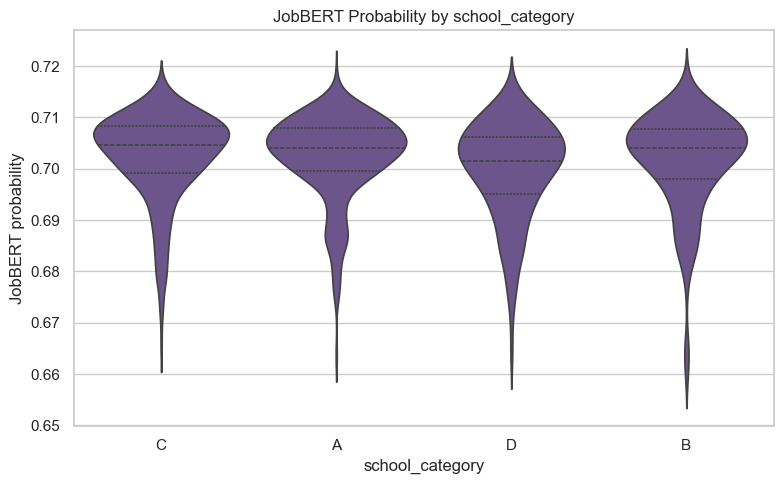

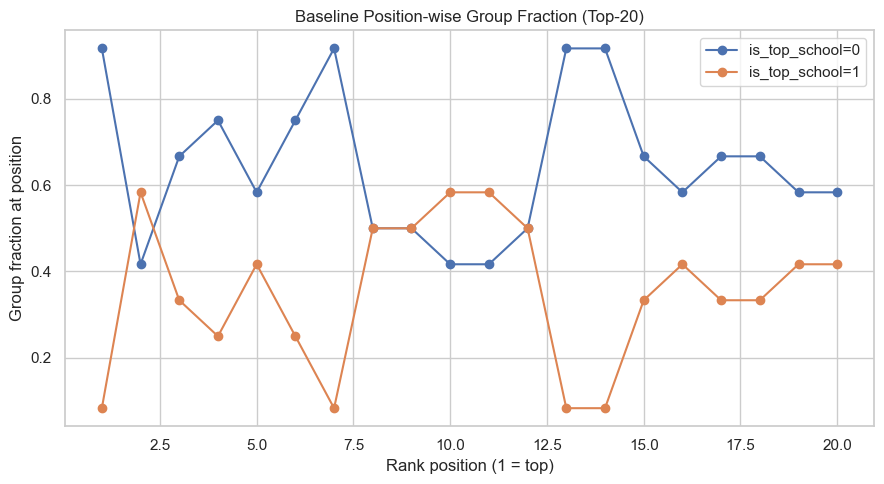

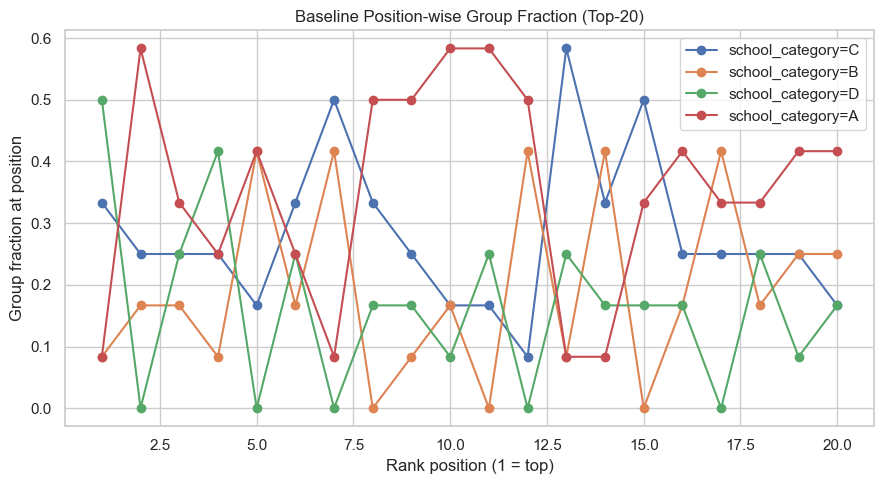

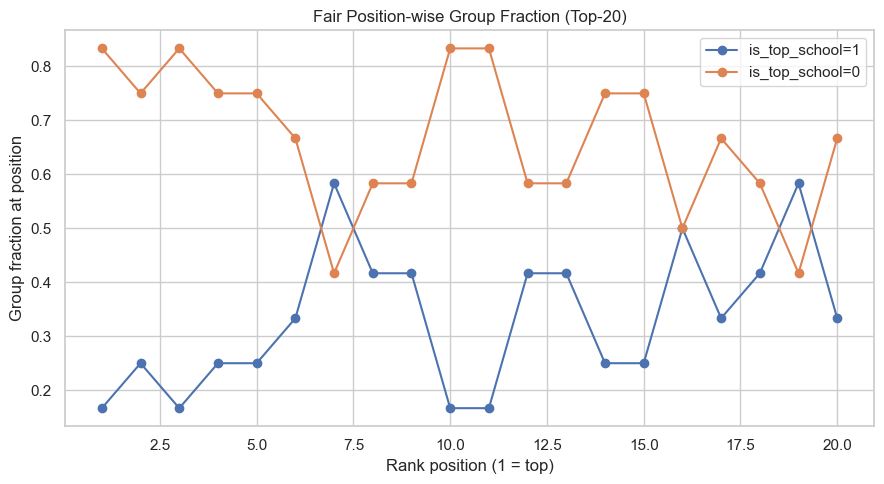

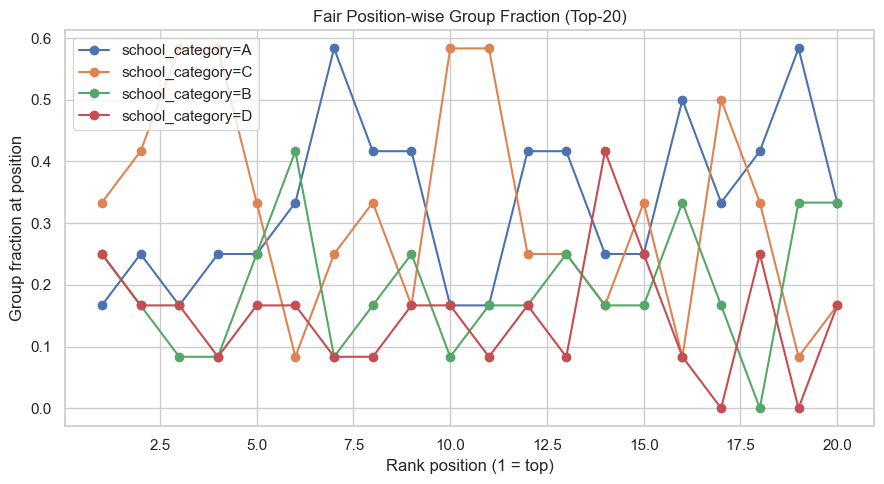

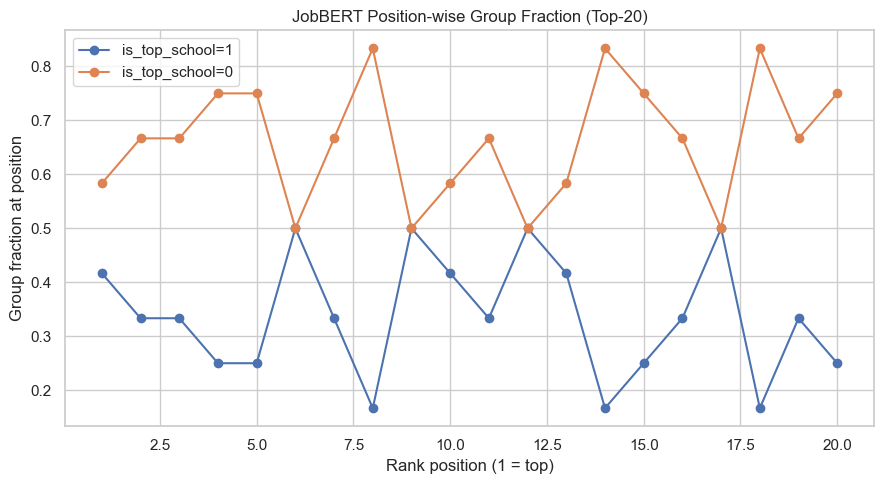

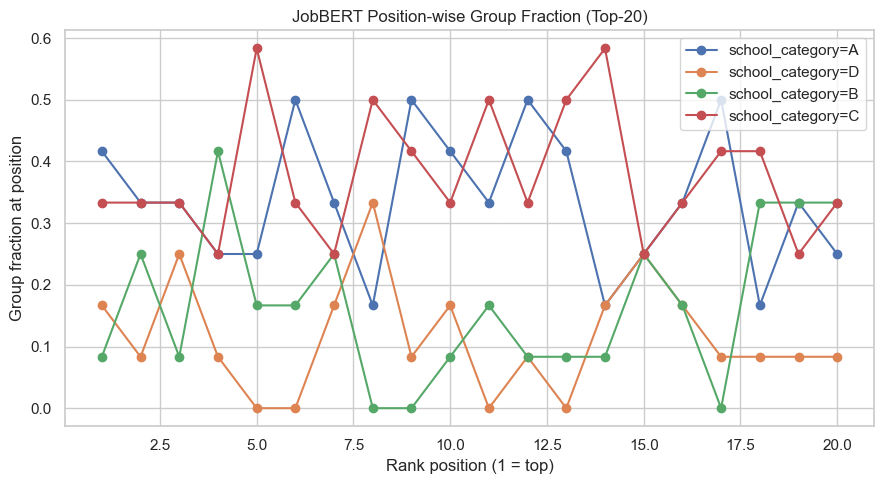

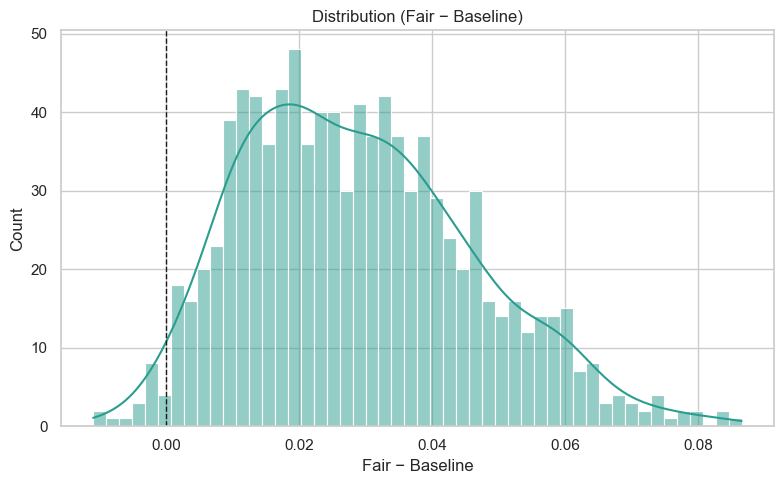

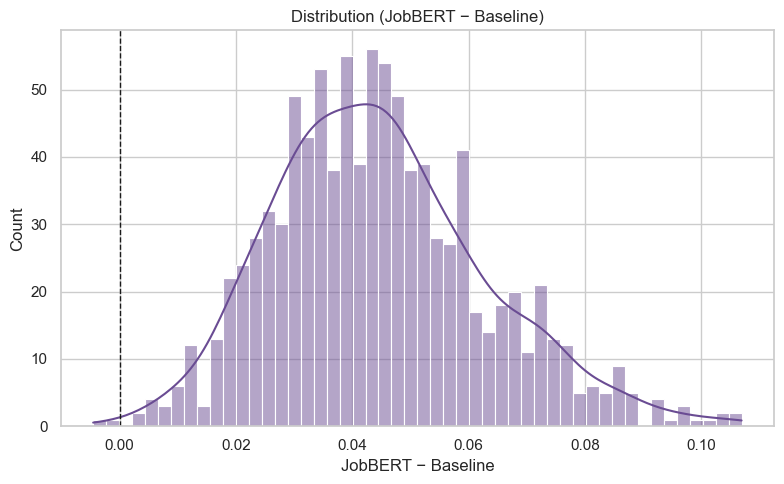

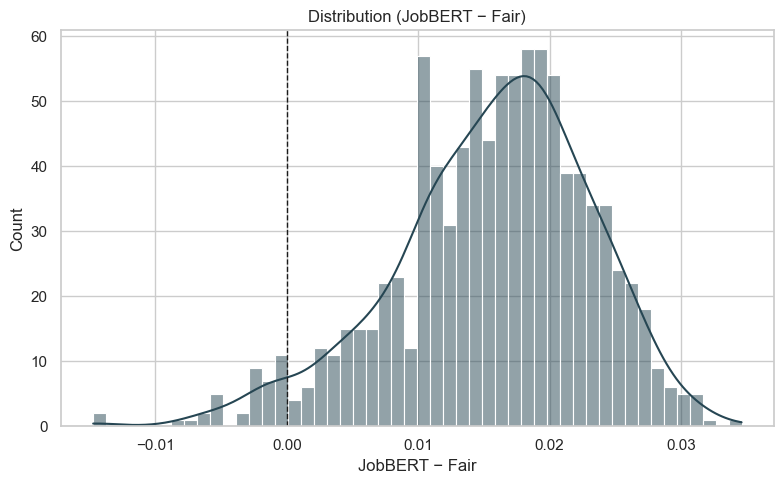

python-ternary unavailable or failed; falling back to 2D projection. No module named 'ternary'


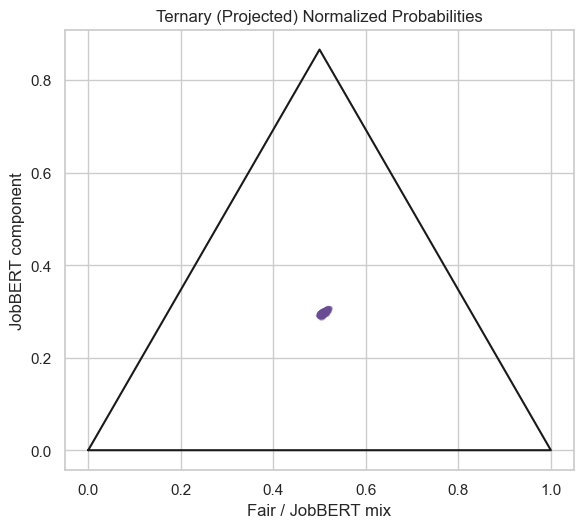

Additional visuals (incl. ternary) completed. Figures saved to: ../reports/fairness_metrics


In [15]:
# 11) Additional Visual Insights Code (+ Ternary Plot)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
SAVE_FIGS = globals().get('SAVE_FIGS', True)
FIG_DIR = Path('..') / 'reports' /  'fairness_metrics'
if SAVE_FIGS:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

# 11.1 Pairwise probability scatters
def scatter_pair(x, y, xlab, ylab, title, fname):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x, y, s=8, alpha=0.25)
    lims = [0,1]
    ax.plot(lims, lims, 'r--', linewidth=1)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel(xlab); ax.set_ylabel(ylab); ax.set_title(title)
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(FIG_DIR / fname, dpi=200)
    plt.show()

try:
    if all(c in df_all.columns for c in ['baseline_prob','fair_prob','bert_prob']):
        n = len(df_all)
        x_b = df_all['baseline_prob'].values
        x_f = df_all['fair_prob'].values
        x_j = df_all['bert_prob'].values
        scatter_pair(x_b, x_f, 'Baseline prob','Fair prob','Baseline vs Fair','scatter_baseline_fair.png')
        scatter_pair(x_b, x_j, 'Baseline prob','JobBERT prob','Baseline vs JobBERT','scatter_baseline_jobbert.png')
        scatter_pair(x_f, x_j, 'Fair prob','JobBERT prob','Fair vs JobBERT','scatter_fair_jobbert.png')
except Exception as e:
    print('Pairwise scatters skipped:', e)

# 11.2 Group-wise violins (including JobBERT)
for group_col in ['is_top_school','school_category']:
    try:
        if group_col in df_all.columns:
            for model_name, pcol, color in [('Baseline','baseline_prob','#999'),('Fair','fair_prob','#2a9d8f'),('JobBERT','bert_prob','#6a4c93')]:
                if pcol in df_all.columns:
                    fig, ax = plt.subplots(figsize=(8,5))
                    sns.violinplot(data=df_all, x=group_col, y=pcol, ax=ax, inner='quartile', color=color)
                    ax.set_title(f'{model_name} Probability by {group_col}')
                    ax.set_xlabel(group_col); ax.set_ylabel(f'{model_name} probability')
                    plt.tight_layout()
                    if SAVE_FIGS:
                        plt.savefig(FIG_DIR / f'violin_{model_name.lower()}_{group_col}.png', dpi=200)
                    plt.show()
    except Exception as e:
        print(f'Violins for {group_col} skipped:', e)

# 11.3 Exposure curves across ranks (each model)
def exposure_curve(df: pd.DataFrame, prob_col: str, job_col='job_id', group_col='is_top_school', max_k=20):
    if not all(c in df.columns for c in [prob_col, job_col, group_col]):
        return None
    pos_counts = {}
    pos_totals = np.zeros(max_k, dtype=float)
    for _, g in df.groupby(job_col):
        g_sorted = g.sort_values(prob_col, ascending=False).head(max_k)
        for idx, (_, row) in enumerate(g_sorted.iterrows()):
            grp = row[group_col]
            pos_counts.setdefault(grp, np.zeros(max_k, dtype=float))[idx] += 1.0
            pos_totals[idx] += 1.0
    if pos_totals.sum() == 0:
        return None
    curves = {str(k): (v / np.maximum(pos_totals,1e-9)).tolist() for k, v in pos_counts.items()}
    return curves

try:
    for model_name, pcol in [('Baseline','baseline_prob'),('Fair','fair_prob'),('JobBERT','bert_prob')]:
        for group_col in ['is_top_school','school_category']:
            curves = exposure_curve(df_all, pcol, job_col='job_id', group_col=group_col, max_k=20)
            if curves:
                fig, ax = plt.subplots(figsize=(9,5))
                for grp, ys in curves.items():
                    ax.plot(range(1,len(ys)+1), ys, marker='o', label=f'{group_col}={grp}')
                ax.set_title(f'{model_name} Position-wise Group Fraction (Top-20)')
                ax.set_xlabel('Rank position (1 = top)'); ax.set_ylabel('Group fraction at position')
                ax.legend(); plt.tight_layout()
                if SAVE_FIGS:
                    plt.savefig(FIG_DIR / f'exposure_curve_{model_name.lower()}_{group_col}.png', dpi=200)
                plt.show()
except Exception as e:
    print('Exposure curves skipped:', e)

# 11.4 Probability differences histograms
try:
    if all(c in df_all.columns for c in ['baseline_prob','fair_prob','bert_prob']):
        diff_fair_base = df_all['fair_prob'] - df_all['baseline_prob']
        diff_bert_base = df_all['bert_prob'] - df_all['baseline_prob']
        diff_bert_fair = df_all['bert_prob'] - df_all['fair_prob']
        for arr, title, fname, color in [
            (diff_fair_base,'Distribution (Fair − Baseline)','diff_fair_minus_baseline.png','#2a9d8f'),
            (diff_bert_base,'Distribution (JobBERT − Baseline)','diff_jobbert_minus_baseline.png','#6a4c93'),
            (diff_bert_fair,'Distribution (JobBERT − Fair)','diff_jobbert_minus_fair.png','#264653')
]:
            fig, ax = plt.subplots(figsize=(8,5))
            sns.histplot(arr, bins=50, kde=True, ax=ax, color=color)
            ax.axvline(0, color='k', linestyle='--', linewidth=1)
            ax.set_title(title); ax.set_xlabel(title.split('(')[1].rstrip(')')); ax.set_ylabel('Count')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / fname, dpi=200)
            plt.show()
except Exception as e:
    print('Difference histograms skipped:', e)

# 11.5 Ternary plot of normalized probabilities
try:
    ternary_ready = all(c in df_all.columns for c in ['baseline_prob','fair_prob','bert_prob'])
    if ternary_ready:
        probs = df_all[['baseline_prob','fair_prob','bert_prob']].clip(lower=0)
        sums = probs.sum(axis=1)
        sums[sums==0] = 1.0
        tern = probs.div(sums, axis=0)
        # Downsample for clarity if too large
        SAMPLE_TERN = 5000
        if len(tern) > SAMPLE_TERN:
            tern = tern.sample(SAMPLE_TERN, random_state=42)
        try:
            import ternary
            scale = 100
            fig, tax = ternary.figure(scale=scale)
            pts = (tern.values * scale).round().astype(int)
            tax.scatter([tuple(p) for p in pts], marker='o', color='#6a4c93', alpha=0.25, s=10)
            tax.boundary()
            tax.left_axis_label('Fair', offset=0.14)
            tax.right_axis_label('JobBERT', offset=0.14)
            tax.bottom_axis_label('Baseline', offset=0.04)
            tax.set_title('Ternary Distribution of Normalized Probabilities')
            tax.clear_matplotlib_ticks()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'ternary_prob_distribution.png', dpi=200)
            plt.show()
        except Exception as e2:
            print('python-ternary unavailable or failed; falling back to 2D projection.', e2)
            # 2D projection: barycentric to x,y
            b = tern['baseline_prob'].values
            f = tern['fair_prob'].values
            j = tern['bert_prob'].values
            # Coordinates for triangle: Baseline=(0,0), Fair=(1,0), JobBERT=(0.5, sqrt(3)/2)
            x = f + 0.5*j
            y = (np.sqrt(3)/2)*j
            fig, ax = plt.subplots(figsize=(6,6))
            ax.scatter(x, y, s=8, alpha=0.25, color='#6a4c93')
            tri = np.array([[0,0],[1,0],[0.5,np.sqrt(3)/2],[0,0]])
            ax.plot(tri[:,0], tri[:,1], 'k-')
            ax.set_title('Ternary (Projected) Normalized Probabilities')
            ax.set_xlabel('Fair / JobBERT mix'); ax.set_ylabel('JobBERT component')
            ax.set_aspect('equal','box')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'ternary_prob_distribution_projected.png', dpi=200)
            plt.show()
except Exception as e:
    print('Ternary plot skipped:', e)

print('Additional visuals (incl. ternary) completed. Figures saved to:', FIG_DIR if SAVE_FIGS else 'not saved')

In [16]:
# 12) Quick JobBERT scoring + merge with existing CSVs (safe to run standalone)
import numpy as np
import pandas as pd
import torch
from pathlib import Path

# Resolve data dir regardless of earlier cells
DATA_DIR = globals().get('DATA_DIR', Path('..') / 'data' / 'eval')
pairs_path = DATA_DIR / 'pairs_longtext.csv'
cf_path    = DATA_DIR / 'counterfactual_pairs_longtext.csv'
assert pairs_path.exists() and cf_path.exists(), 'Required eval CSVs missing.'

# Load JobBERT
try:
    from sentence_transformers import SentenceTransformer
    device_name = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
    jobbert_quick = SentenceTransformer('TechWolf/JobBERT-v2', device=device_name)
    print('JobBERT ready on', device_name)
except Exception as e:
    raise RuntimeError(f'JobBERT not available: {e}')

def encode_jobbert_np(model, texts, batch_size=8):
    if not texts: return np.empty((0,))
    # encode returns normalized embeddings if normalize_embeddings=True (3.x)
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            arr = model.encode(batch, convert_to_numpy=True, normalize_embeddings=True)
        embs.append(arr)
    return np.concatenate(embs, axis=0) if embs else np.empty((0,))

def bert_match_prob(resumes, jobs, batch_size=8):
    ea = encode_jobbert_np(jobbert_quick, resumes, batch_size=batch_size)
    eb = encode_jobbert_np(jobbert_quick, jobs, batch_size=batch_size)
    cos = (ea * eb).sum(axis=1)
    prob = 1/(1+np.exp(-cos))
    return prob, cos

# 12.1 Pairs: compute bert and merge with baseline/fair files if they exist
df_pairs = pd.read_csv(pairs_path).fillna('')
bert_prob, bert_cos = bert_match_prob(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), batch_size=globals().get('BATCH_JOBBERT', 8))
df_pairs_bert = df_pairs.copy()
df_pairs_bert['bert_prob'] = bert_prob
df_pairs_bert['bert_raw_cosine'] = bert_cos

# Merge with existing scored files when available
out_all = DATA_DIR / 'all_models_scored.csv'
base_csv = DATA_DIR / 'baseline_scored.csv'
fair_csv = DATA_DIR / 'fair_scored.csv'
if base_csv.exists():
    df_base = pd.read_csv(base_csv)
    if 'baseline_prob' in df_base:
        df_pairs_bert['baseline_prob'] = df_base['baseline_prob'].values
        if 'baseline_raw_cosine' in df_base:
            df_pairs_bert['baseline_raw_cosine'] = df_base['baseline_raw_cosine'].values
if fair_csv.exists():
    df_fair = pd.read_csv(fair_csv)
    if 'fair_prob' in df_fair:
        df_pairs_bert['fair_prob'] = df_fair['fair_prob'].values
        if 'fair_raw_cosine' in df_fair:
            df_pairs_bert['fair_raw_cosine'] = df_fair['fair_raw_cosine'].values

df_pairs_bert.to_csv(out_all, index=False)
print('Wrote unified pairs file:', out_all)

# 12.2 Counterfactual: compute bert and append to existing counterfactual_scored.csv if present
df_cf = pd.read_csv(cf_path).fillna('')
bert_prob_orig, _ = bert_match_prob(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), batch_size=globals().get('BATCH_JOBBERT', 8))
bert_prob_cf,   _ = bert_match_prob(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), batch_size=globals().get('BATCH_JOBBERT', 8))

cf_out = DATA_DIR / 'counterfactual_scored.csv'
if cf_out.exists():
    df_cf_scored = pd.read_csv(cf_out)
else:
    df_cf_scored = df_cf.copy()
df_cf_scored['bert_prob_orig'] = bert_prob_orig
df_cf_scored['bert_prob_cf']   = bert_prob_cf
df_cf_scored.to_csv(cf_out, index=False)
print('Updated counterfactual file:', cf_out)

JobBERT ready on mps
Wrote unified pairs file: ../data/eval/all_models_scored.csv
Wrote unified pairs file: ../data/eval/all_models_scored.csv
Updated counterfactual file: ../data/eval/counterfactual_scored.csv
Updated counterfactual file: ../data/eval/counterfactual_scored.csv


Saved: ../reports/fairness_metrics/fairness_radar.png


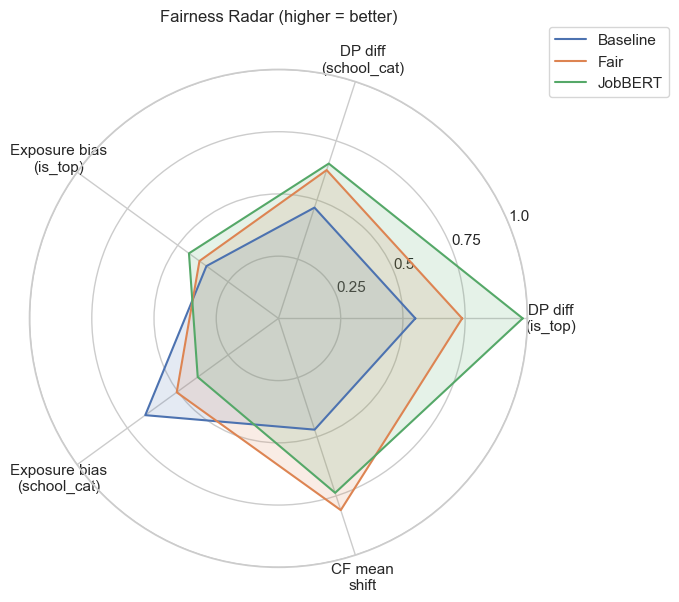

In [17]:
# 12) Fairness Radar (fixed ranges; higher = better)
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

FIG_DIR = Path('..') / 'reports' / 'fairness_metrics'
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Raw metrics (lower = fairer)
metrics = {
    "DP_diff_is_top": {"Baseline": 0.0225, "Fair": 0.0131, "JobBERT": 0.00094},
    "DP_diff_school_cat": {"Baseline": 0.1064, "Fair": 0.0747, "JobBERT": 0.0692},
    "Expo_bias_is_top": {"Baseline": 0.3854, "Fair": 0.3646, "JobBERT": 0.3333},
    "Expo_bias_school_cat": {"Baseline": 0.1354, "Fair": 0.1979, "JobBERT": 0.2396},
    "CF_mean_shift": {"Baseline": 0.0159, "Fair": 0.0057, "JobBERT": 0.00789},
}

# Fixed expected ranges per metric (tune as needed)
RANGES = {
    "DP_diff_is_top": (0.0, 0.05),
    "DP_diff_school_cat": (0.0, 0.20),
    "Expo_bias_is_top": (0.0, 0.60),
    "Expo_bias_school_cat": (0.0, 0.40),
    "CF_mean_shift": (0.0, 0.03),
}

FLOOR = 0.05  # avoid degenerate zero polygons
models = ["Baseline", "Fair", "JobBERT"]
dims = list(metrics.keys())

fair_scores = {m: [] for m in models}
for dim in dims:
    lo, hi = RANGES[dim]
    for m in models:
        v = metrics[dim][m]
        s = 1.0 - (v - lo) / max(hi - lo, 1e-9)  # lower is better
        s = float(np.clip(s, 0.0, 1.0))
        fair_scores[m].append(max(s, FLOOR))

# Radar chart
num_vars = len(dims)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
def close(vals): return vals + vals[:1]

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)
for model, color in zip(models, ['tab:blue', 'tab:green', 'tab:orange']):
    vals = fair_scores[model]
    ax.plot(angles, close(vals), label=model)
    ax.fill(angles, close(vals), alpha=0.15)

labels = [
    "DP diff\n(is_top)",
    "DP diff\n(school_cat)",
    "Exposure bias\n(is_top)",
    "Exposure bias\n(school_cat)",
    "CF mean\nshift",
]
ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
ax.set_yticks([0.25, 0.5, 0.75, 1.0]); ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
ax.set_ylim(0, 1)
plt.title("Fairness Radar (higher = better)", y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
path = FIG_DIR / 'fairness_radar.png'
plt.savefig(path, dpi=200)
print('Saved:', path)

## XAI: Explainability Analysis (Attention & Token Attribution)

Compare Baseline vs Fair models using:
1. **Attention Heatmaps**: visualize which tokens the model focuses on
2. **Token Attribution**: measure each token's contribution to the final score
3. **Group Comparison**: analyze attention/attribution differences across demographic groups

In [23]:
# 13) XAI Setup & Helper Functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

XAI_DIR = Path('..') / 'reports' / 'xai'
XAI_DIR.mkdir(parents=True, exist_ok=True)

# Randomly sample test cases from evaluation data
np.random.seed(42)
if 'df_all' in globals() and len(df_all) > 0:
    # Sample from different groups for comparison
    sample_top = df_all[df_all['is_top_school'] == 1].sample(min(2, len(df_all[df_all['is_top_school'] == 1])))
    sample_reg = df_all[df_all['is_top_school'] == 0].sample(min(2, len(df_all[df_all['is_top_school'] == 0])))
    test_samples = pd.concat([sample_top, sample_reg]).reset_index(drop=True)
    print(f"Sampled {len(test_samples)} test cases for XAI analysis:")
    for idx, row in test_samples.iterrows():
        print(f"  [{idx}] is_top_school={row.get('is_top_school', 'N/A')}, "
              f"school_cat={row.get('school_category', 'N/A')}, "
              f"resume_wc={row.get('resume_wc', 'N/A')}")
else:
    print("No evaluation data available; using synthetic examples.")
    test_samples = pd.DataFrame({
        'resume_text': [
            'Senior software engineer with 5 years experience in Python and machine learning. Graduated from Stanford University.',
            'Software developer with strong background in backend systems. Experience with Docker and Kubernetes.'
        ],
        'job_text': [
            'Seeking machine learning engineer with Python expertise and cloud deployment experience.',
            'Backend engineer position requiring microservices architecture and containerization skills.'
        ],
        'is_top_school': [1, 0],
        'school_category': ['A', 'C']
    })

# 13.1 Attention Visualization Helper
def visualize_attention(model, text, title='Attention Weights', max_tokens=50):
    """Extract and visualize last-layer attention weights."""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=min(128, max_tokens)).to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get last layer attention, average across heads
    attn = outputs.attentions[-1].mean(dim=1)[0].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Trim to actual tokens
    n = min(len(tokens), attn.shape[0], max_tokens)
    attn = attn[:n, :n]
    tokens = tokens[:n]
    
    fig, ax = plt.subplots(figsize=(max(8, n*0.4), max(6, n*0.3)))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, 
                cmap='viridis', ax=ax, cbar_kws={'label': 'Attention Weight'})
    ax.set_title(title, fontsize=12)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    return fig, attn, tokens

# 13.2 Token Attribution Helper (Gradient-based)
def token_attribution(model, resume_text, job_text, max_tokens=64):
    """Compute gradient-based attribution for resume tokens given job context."""
    inputs_resume = tokenizer(resume_text, return_tensors='pt', truncation=True, max_length=max_tokens).to(DEVICE)
    inputs_job = tokenizer(job_text, return_tensors='pt', truncation=True, max_length=max_tokens).to(DEVICE)
    
    # Get embedding layer and create leaf tensor with gradients
    embedding_layer = model.get_input_embeddings()
    resume_embeds = embedding_layer(inputs_resume['input_ids']).detach()
    resume_embeds = resume_embeds.detach().clone().requires_grad_(True)
    
    # Forward pass
    with torch.enable_grad():
        resume_output = model(inputs_embeds=resume_embeds, attention_mask=inputs_resume['attention_mask'])
        resume_emb = resume_output.last_hidden_state.mean(1)
        
        with torch.no_grad():
            job_output = model(**inputs_job)
            job_emb = job_output.last_hidden_state.mean(1)
        
        # Compute similarity score
        resume_emb_norm = torch.nn.functional.normalize(resume_emb, p=2, dim=1)
        job_emb_norm = torch.nn.functional.normalize(job_emb, p=2, dim=1)
        score = torch.sigmoid((resume_emb_norm * job_emb_norm).sum())
        
        # Backward to get gradients
        score.backward()
    
    # Aggregate gradient magnitude across embedding dimension
    attr = resume_embeds.grad.abs().sum(dim=-1).squeeze(0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs_resume['input_ids'][0])
    
    return attr, tokens, float(score.item())

print('XAI helpers ready. Test samples prepared.')
print(f'XAI outputs will be saved to: {XAI_DIR}')

Sampled 4 test cases for XAI analysis:
  [0] is_top_school=1, school_cat=A, resume_wc=186
  [1] is_top_school=1, school_cat=A, resume_wc=181
  [2] is_top_school=0, school_cat=D, resume_wc=181
  [3] is_top_school=0, school_cat=B, resume_wc=176
XAI helpers ready. Test samples prepared.
XAI outputs will be saved to: ../reports/xai



=== Attention Heatmap Analysis ===


--- Sample 0 (is_top=1, cat=A) ---
Resume excerpt: I studied at a renowned institution and completed several internships in industry. Communicated trad...
Job excerpt: The position offers opportunities to influence technical direction and to collab...


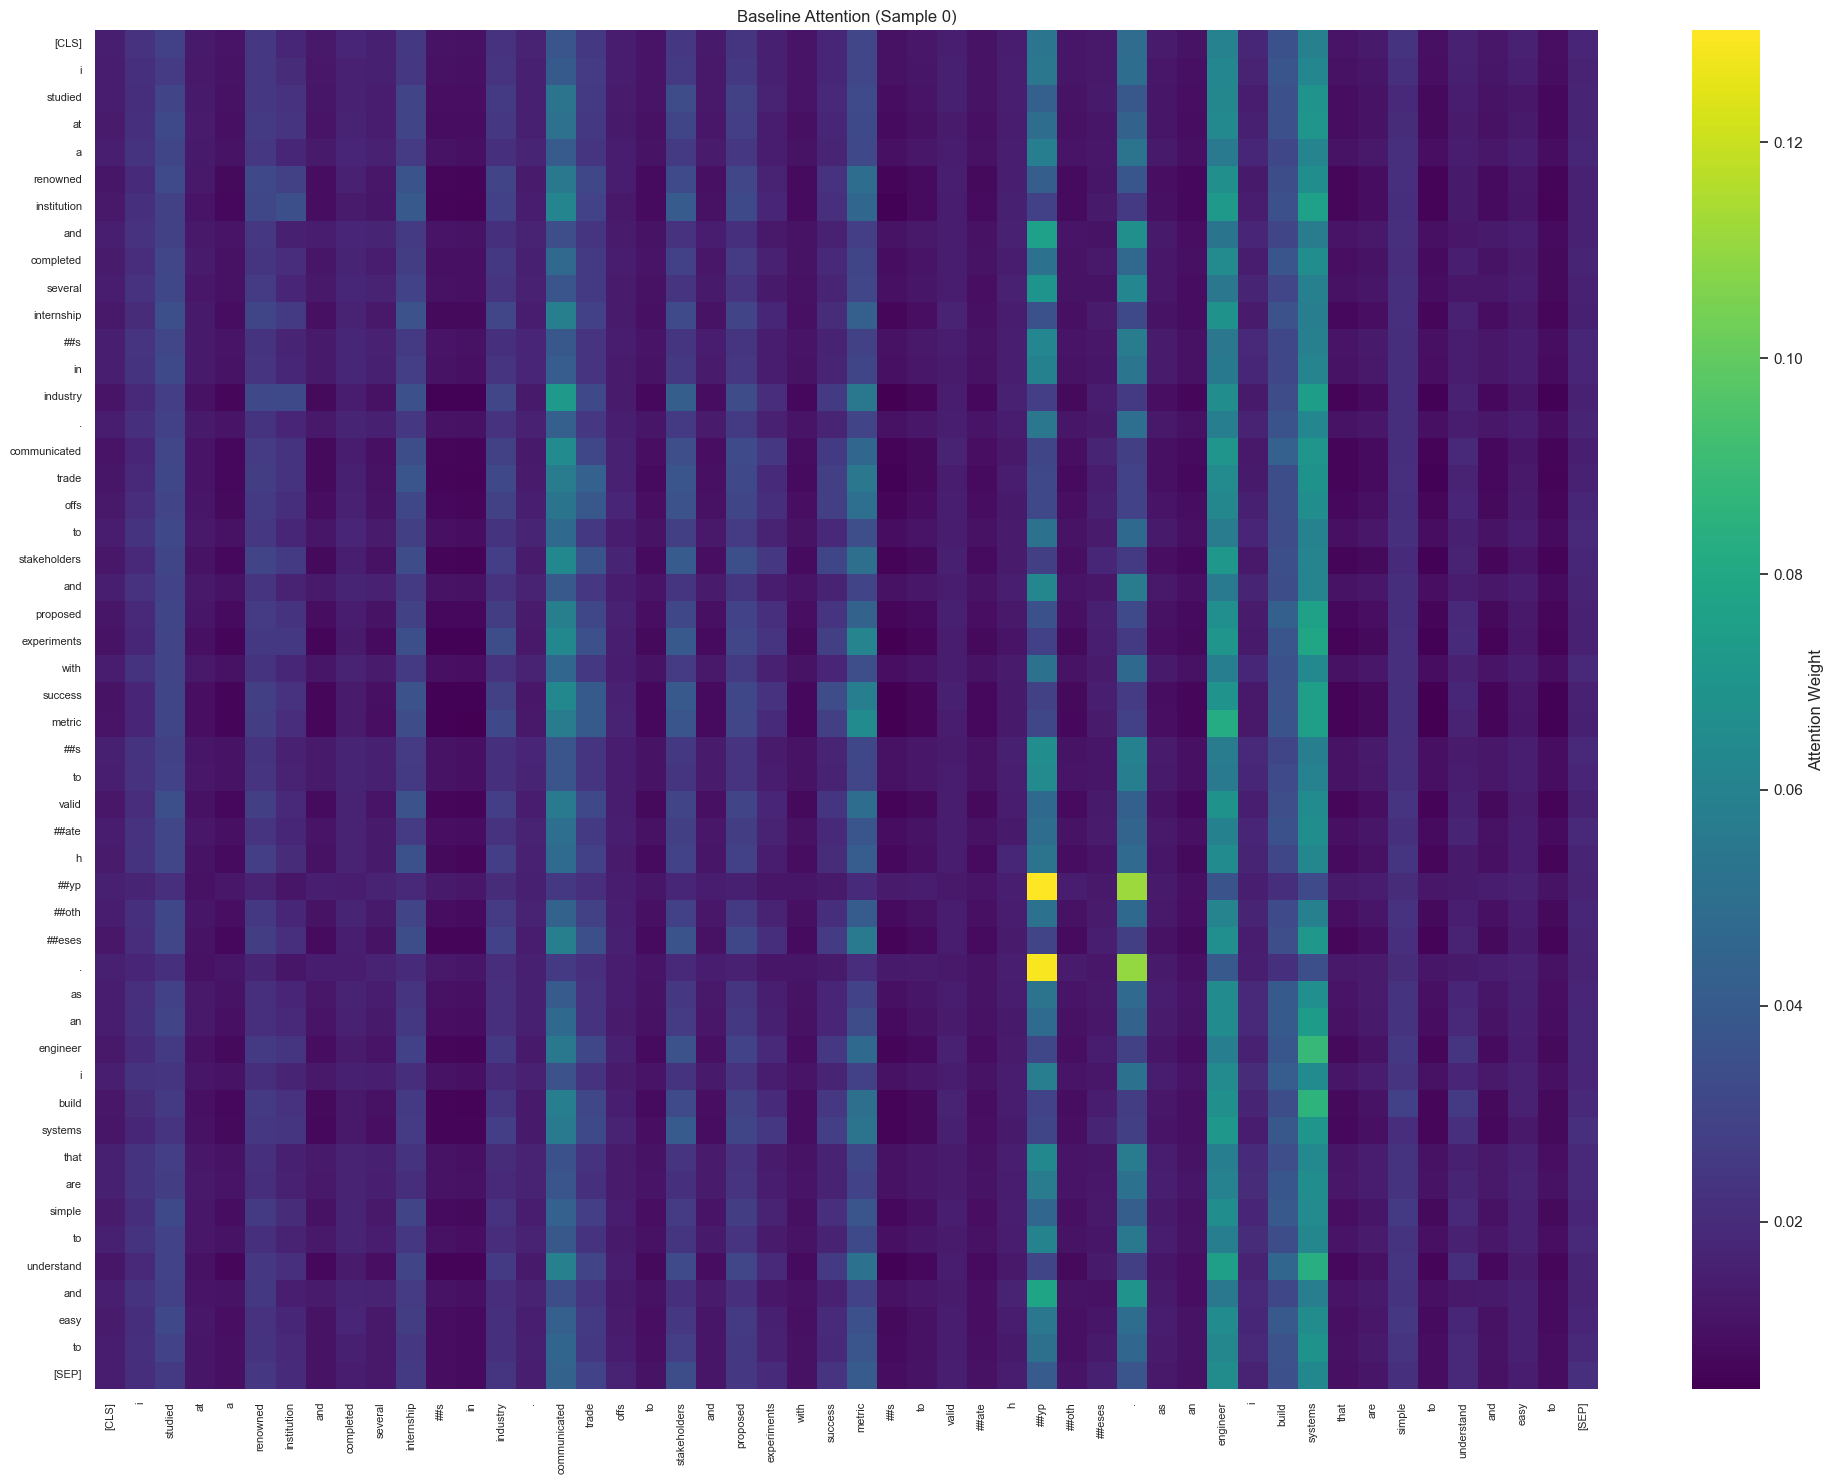

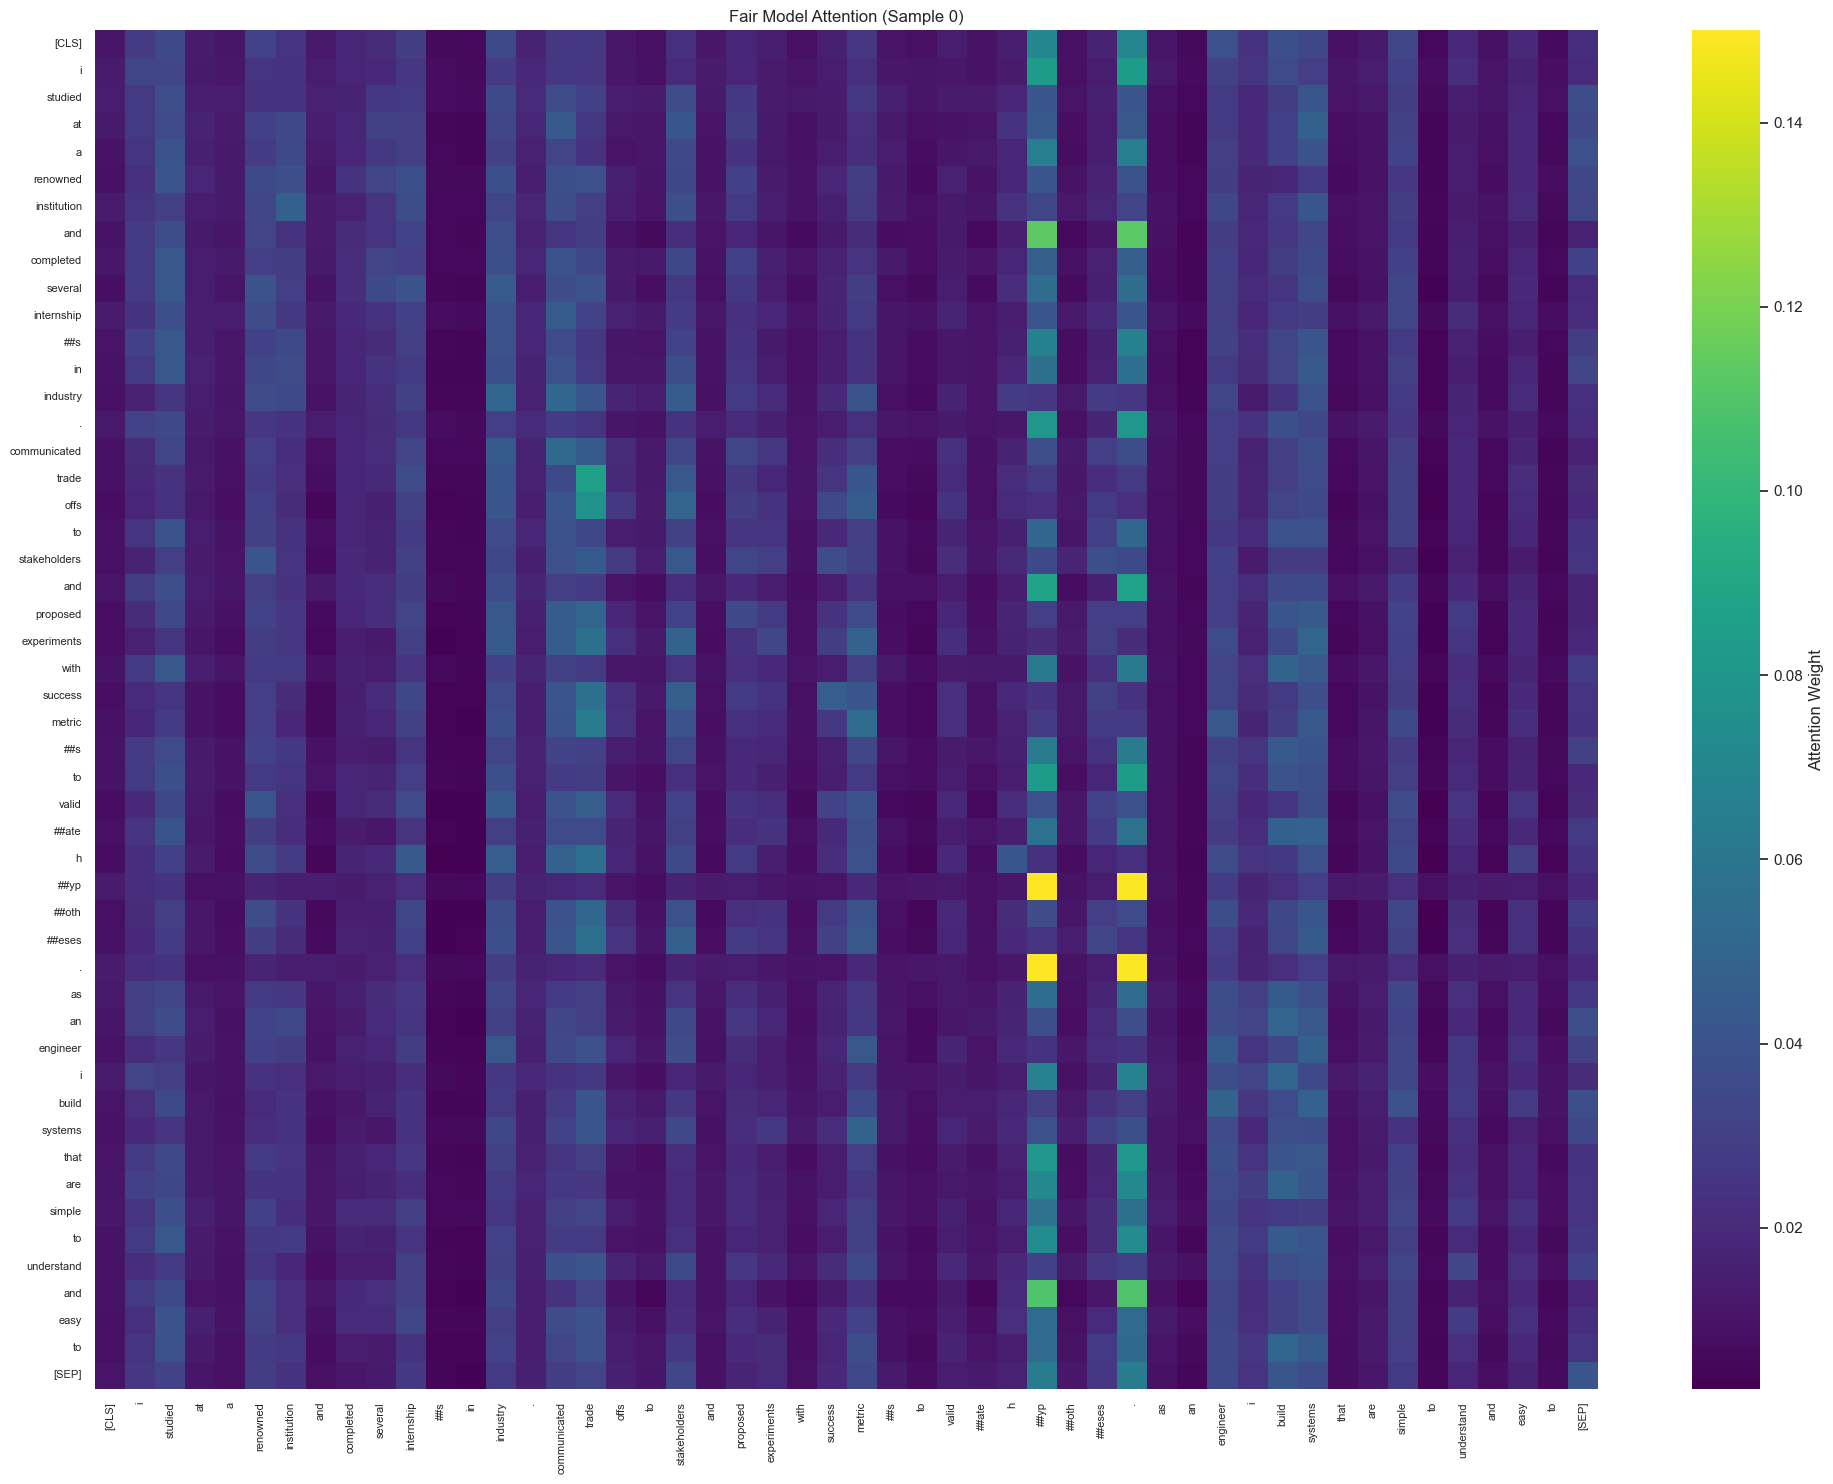

  Top 5 tokens with largest attention change (CLS perspective):
    systems: Δ=0.0248 (Base=0.0588, Fair=0.0340)
    engineer: Δ=0.0218 (Base=0.0603, Fair=0.0385)
    .: Δ=0.0215 (Base=0.0484, Fair=0.0699)
    ##yp: Δ=0.0170 (Base=0.0532, Fair=0.0702)
    industry: Δ=0.0126 (Base=0.0226, Fair=0.0353)

--- Sample 1 (is_top=1, cat=A) ---
Resume excerpt: My background includes building small services, integrating APIs, and shipping features that solve r...
Job excerpt: Candidates should demonstrate practical experience with android, push, kotlin, r...


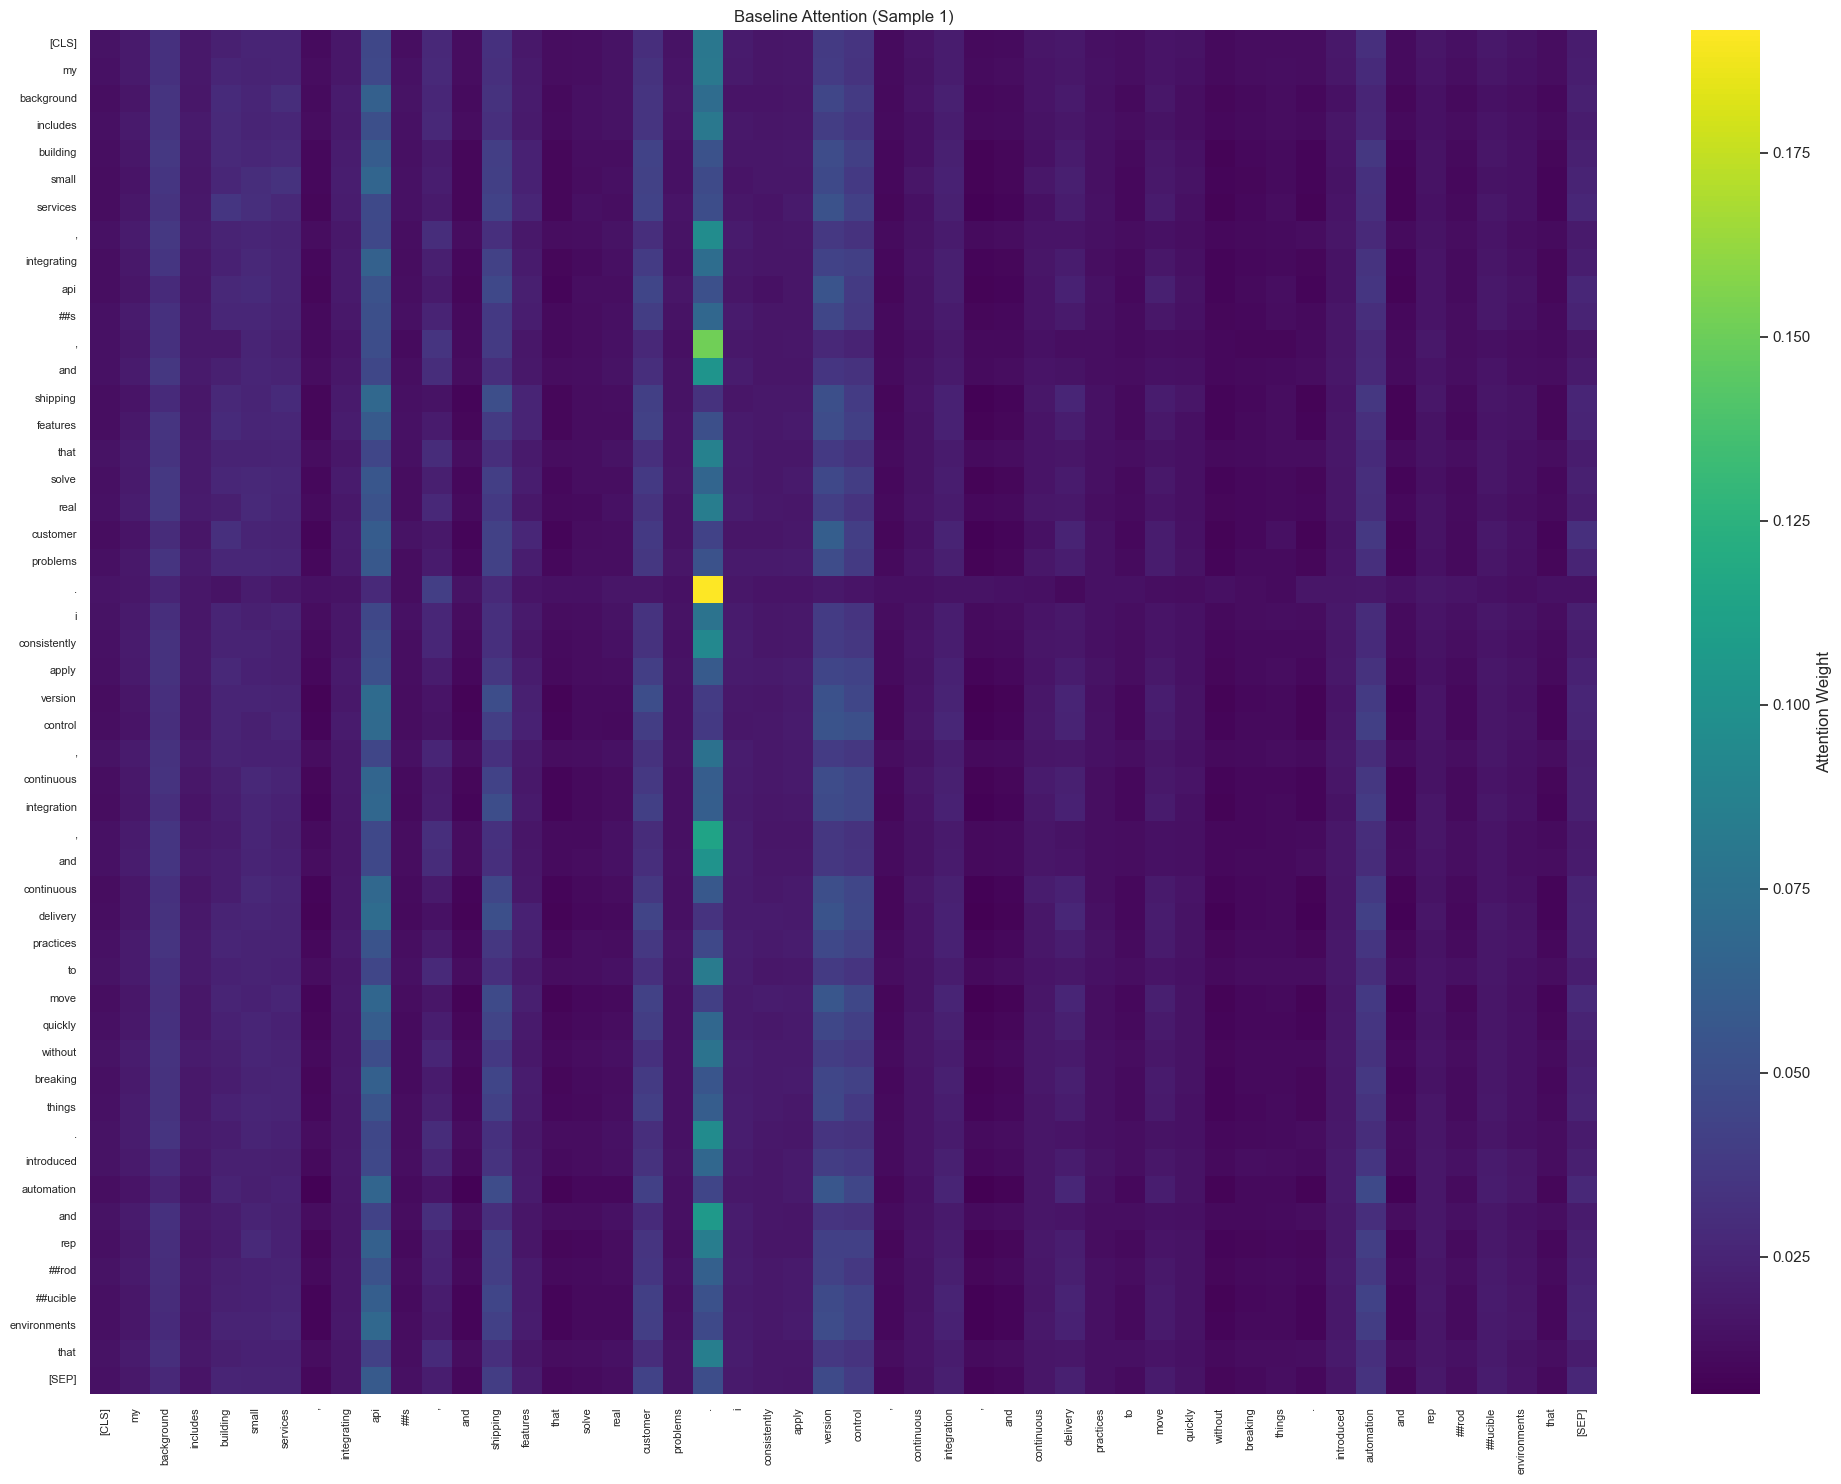

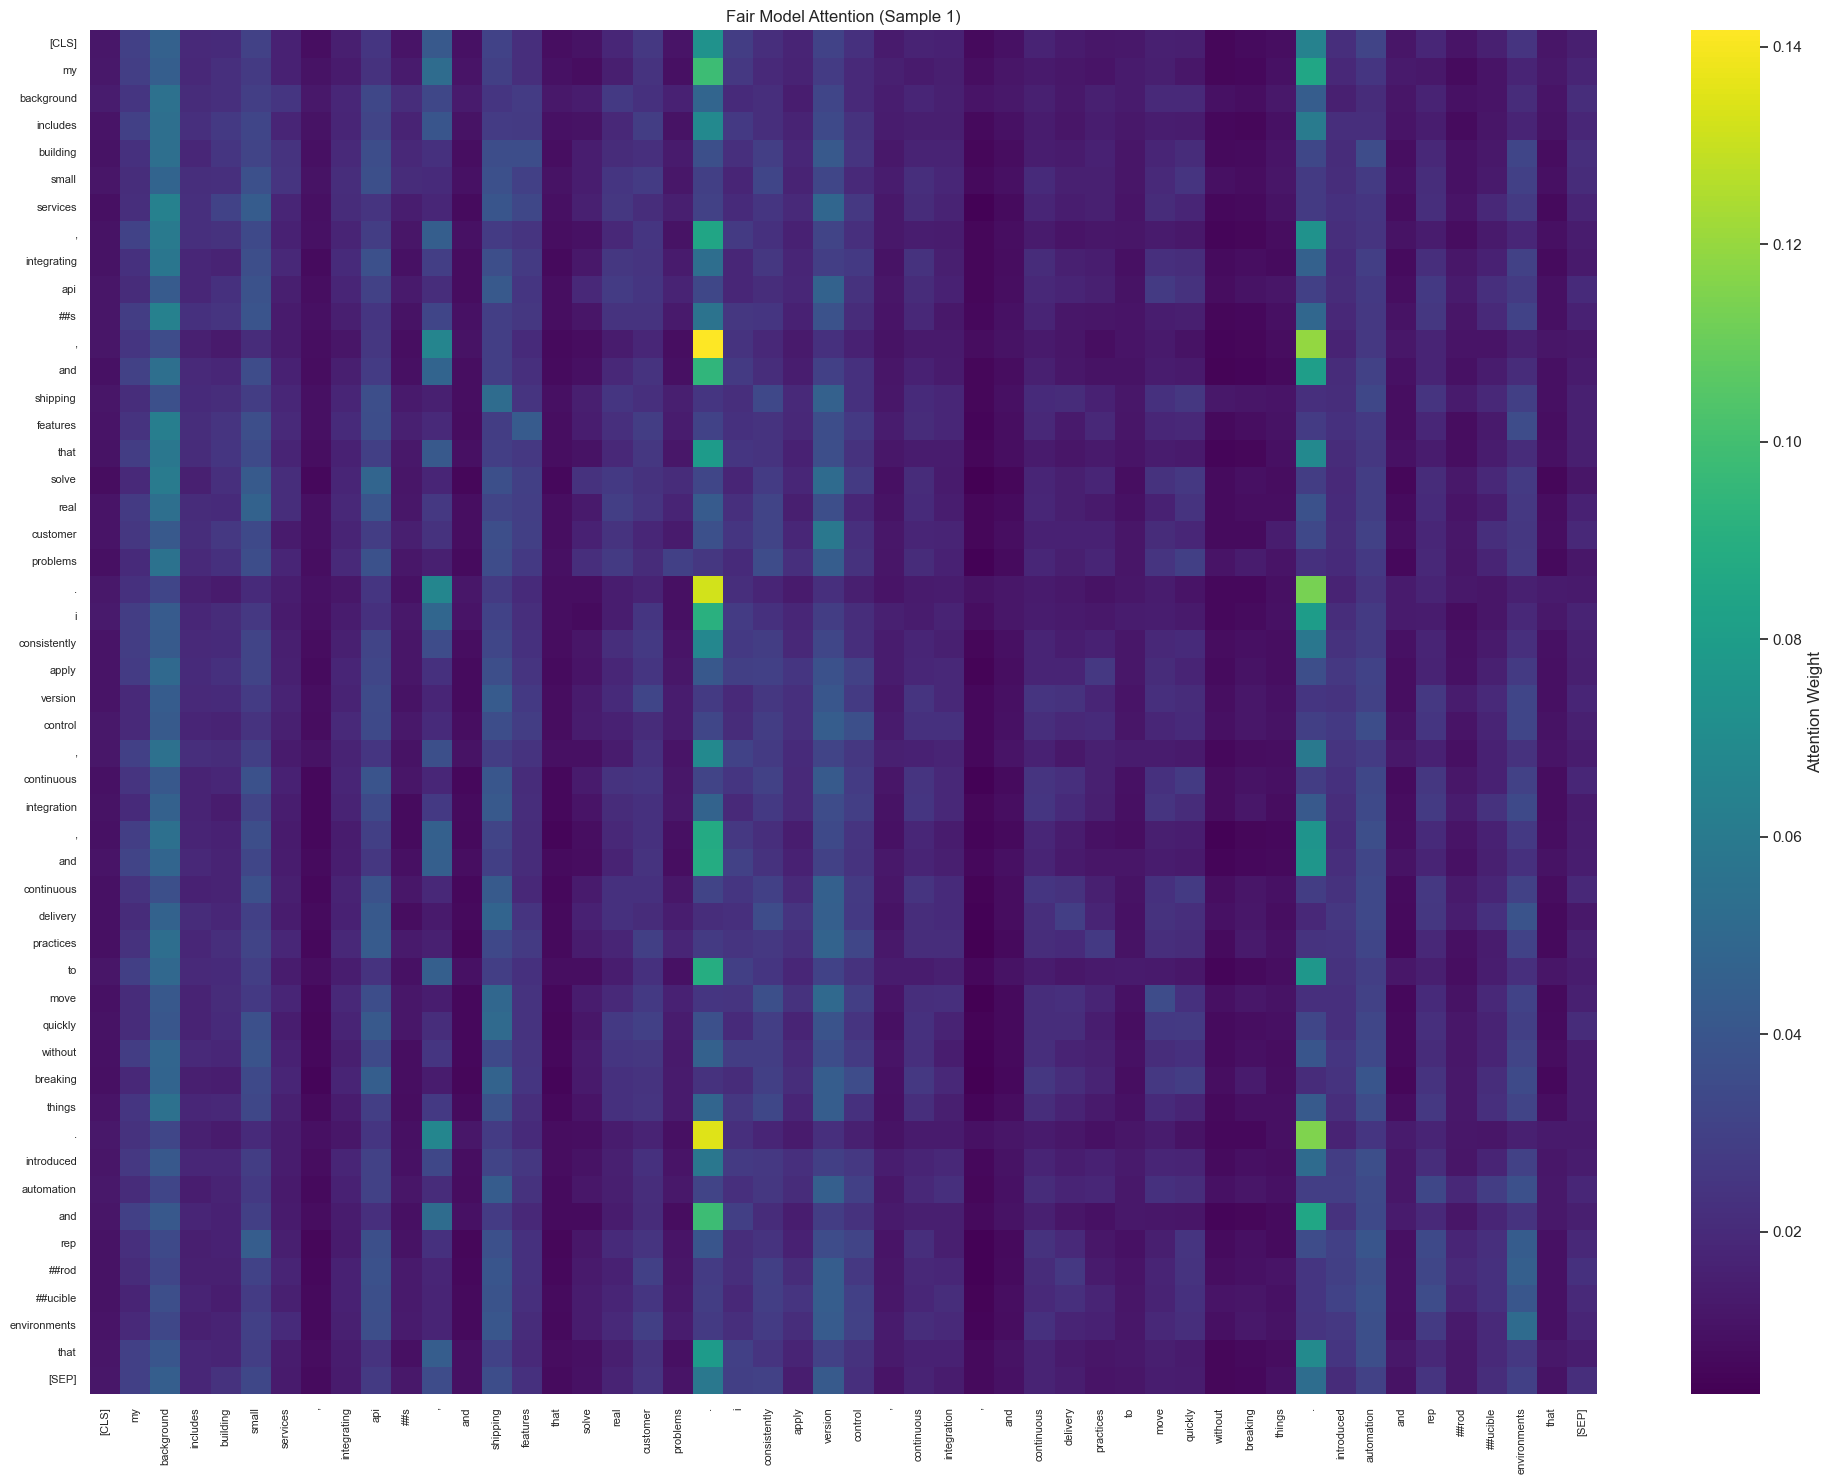

  Top 5 tokens with largest attention change (CLS perspective):
    .: Δ=0.0528 (Base=0.0123, Fair=0.0650)
    api: Δ=0.0212 (Base=0.0460, Fair=0.0248)
    ,: Δ=0.0146 (Base=0.0271, Fair=0.0417)
    background: Δ=0.0140 (Base=0.0320, Fair=0.0459)
    control: Δ=0.0116 (Base=0.0344, Fair=0.0228)

--- Sample 2 (is_top=0, cat=D) ---
Resume excerpt: I am comfortable reading RFCs, writing design documents, and using checklists to keep delivery predi...
Job excerpt: The position offers opportunities to influence technical direction and to collab...


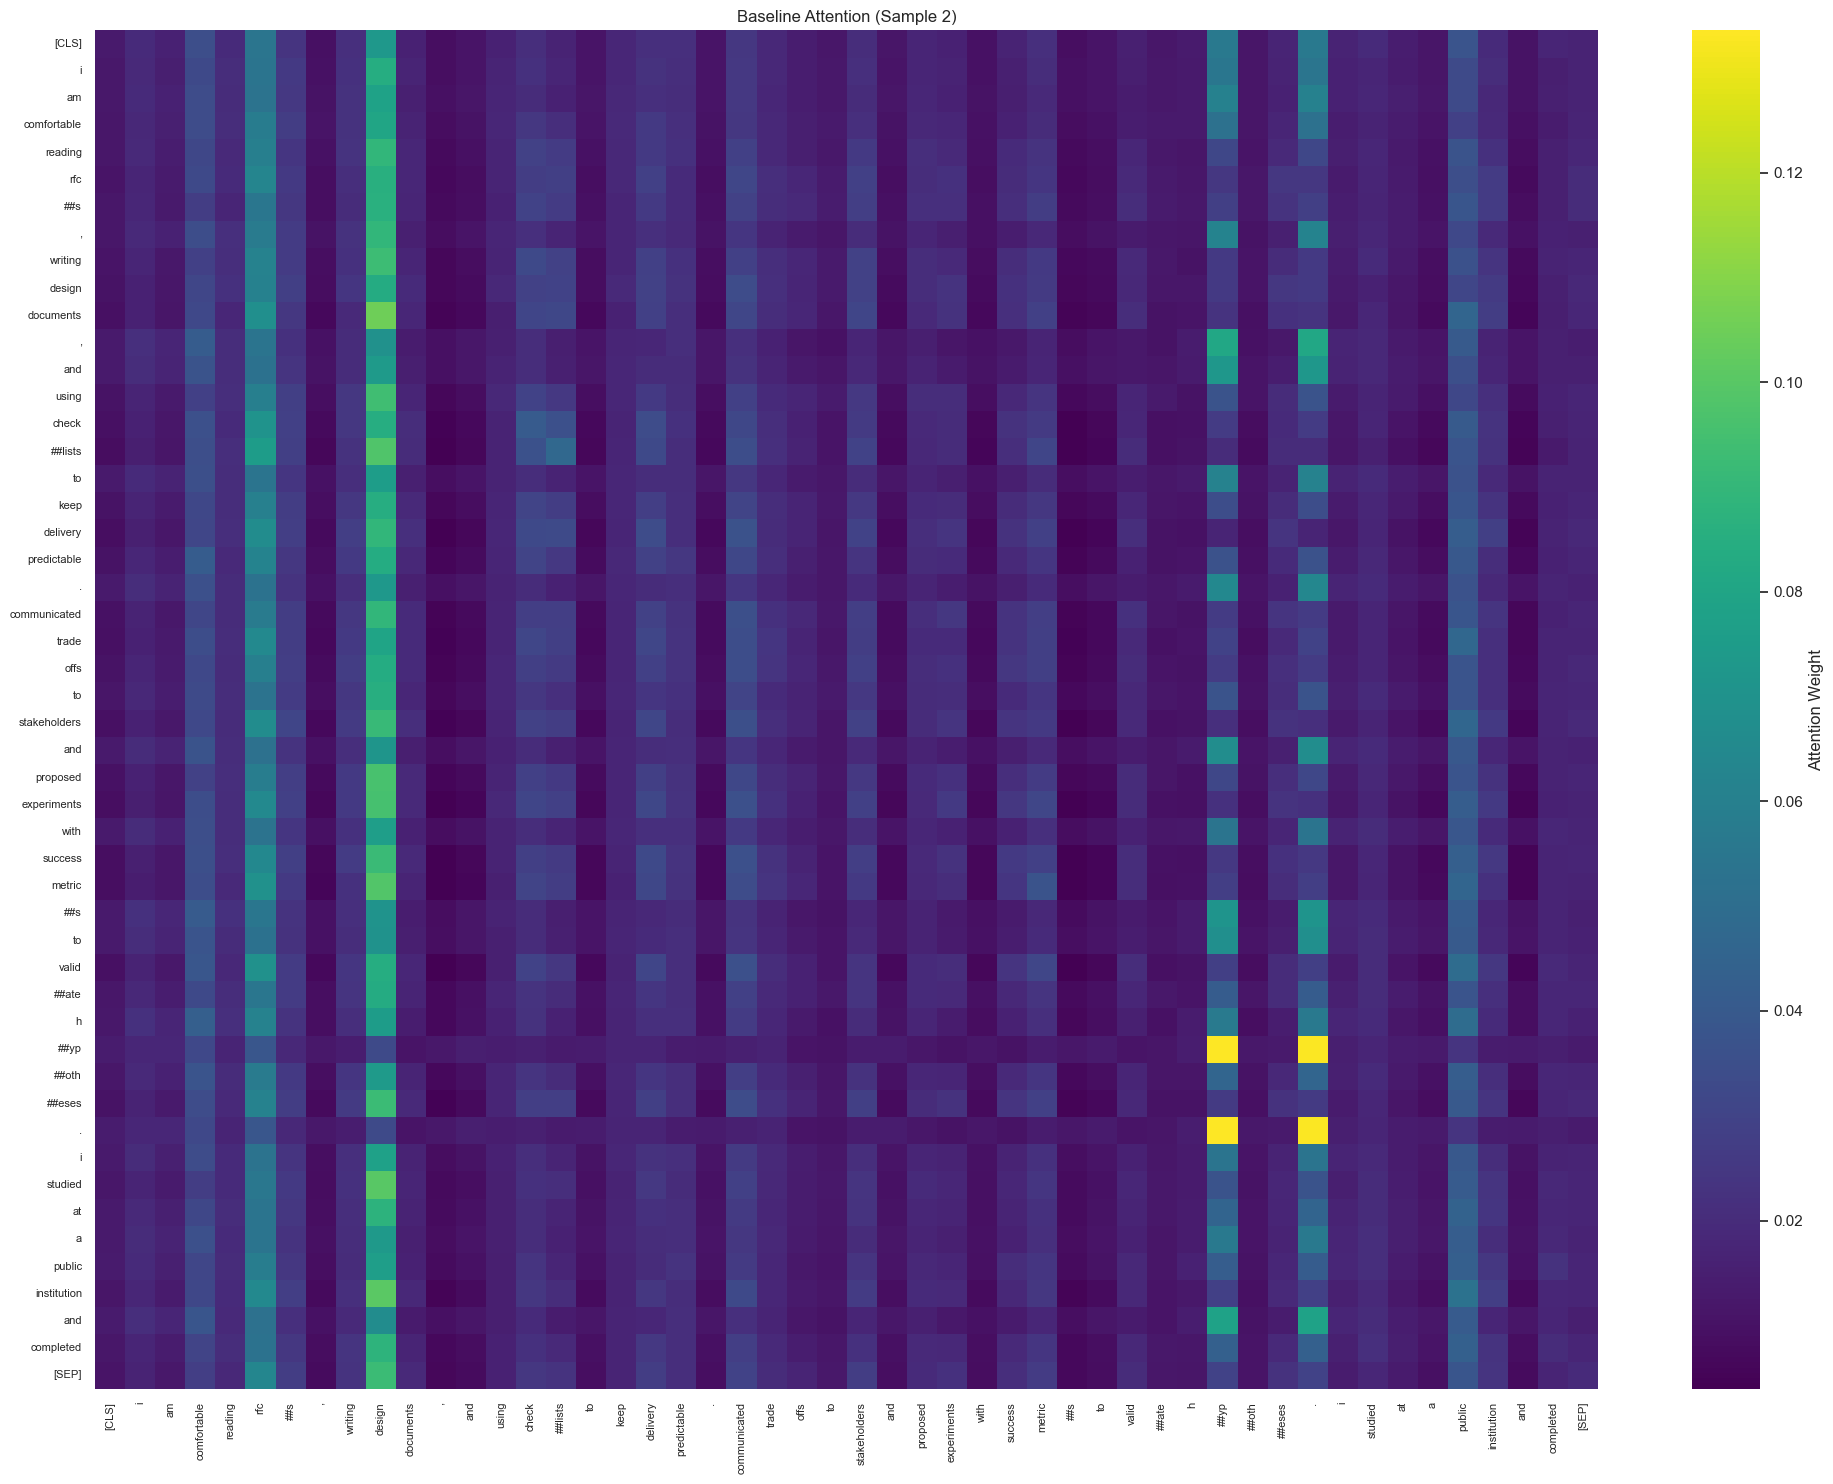

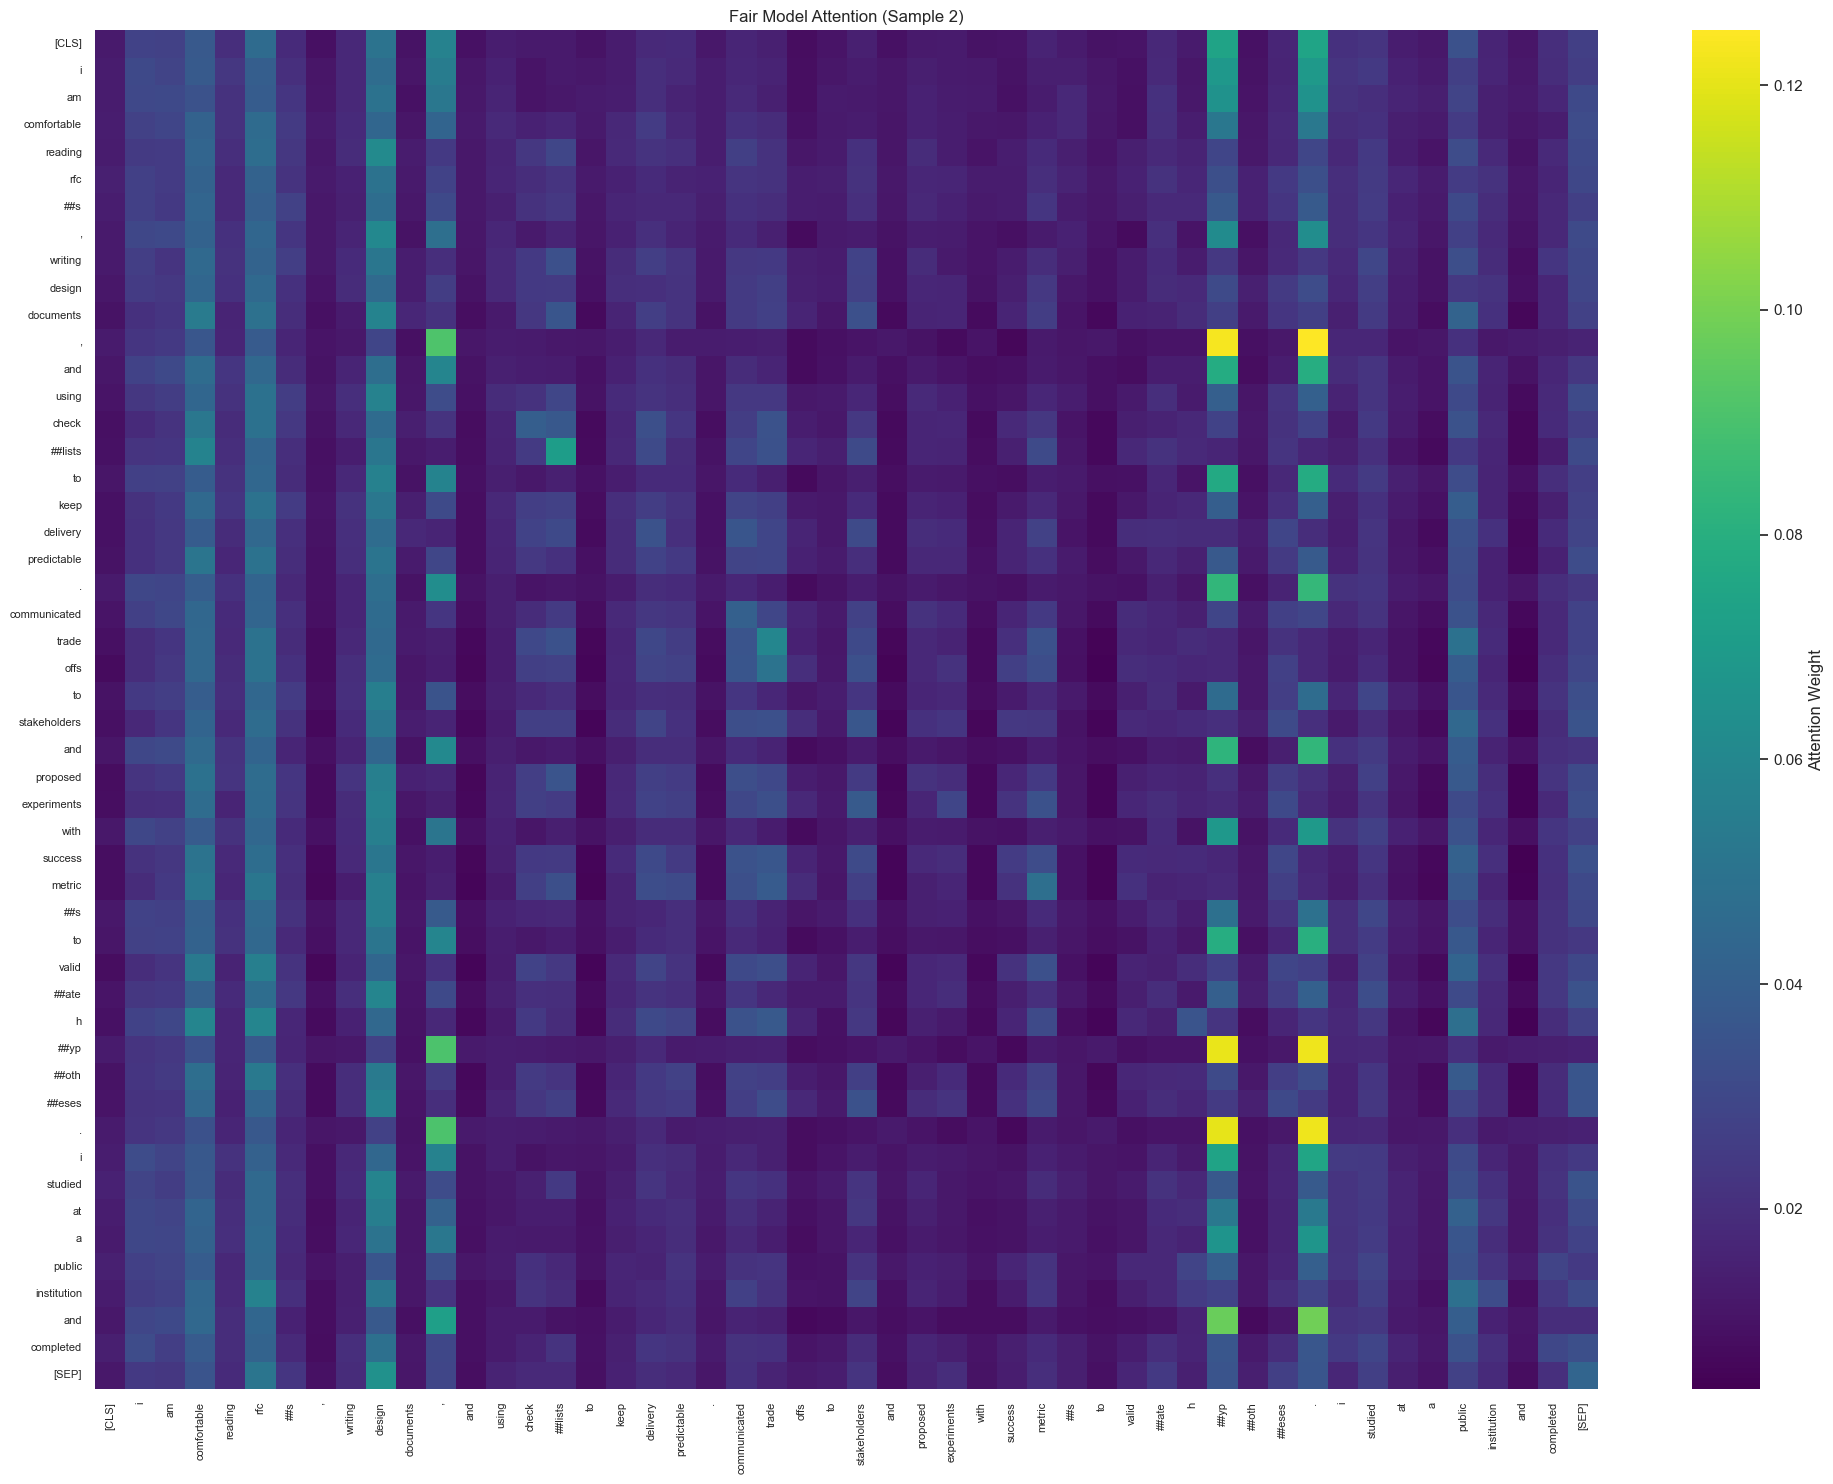

  Top 5 tokens with largest attention change (CLS perspective):
    ,: Δ=0.0483 (Base=0.0086, Fair=0.0569)
    design: Δ=0.0228 (Base=0.0729, Fair=0.0502)
    .: Δ=0.0183 (Base=0.0564, Fair=0.0747)
    ##yp: Δ=0.0174 (Base=0.0565, Fair=0.0739)
    am: Δ=0.0117 (Base=0.0158, Fair=0.0274)

--- Sample 3 (is_top=0, cat=B) ---
Resume excerpt: Mentored peers through code reviews and pairing sessions, emphasizing clarity, naming, and increment...
Job excerpt: You will write readable code, create meaningful tests, and participate in code r...


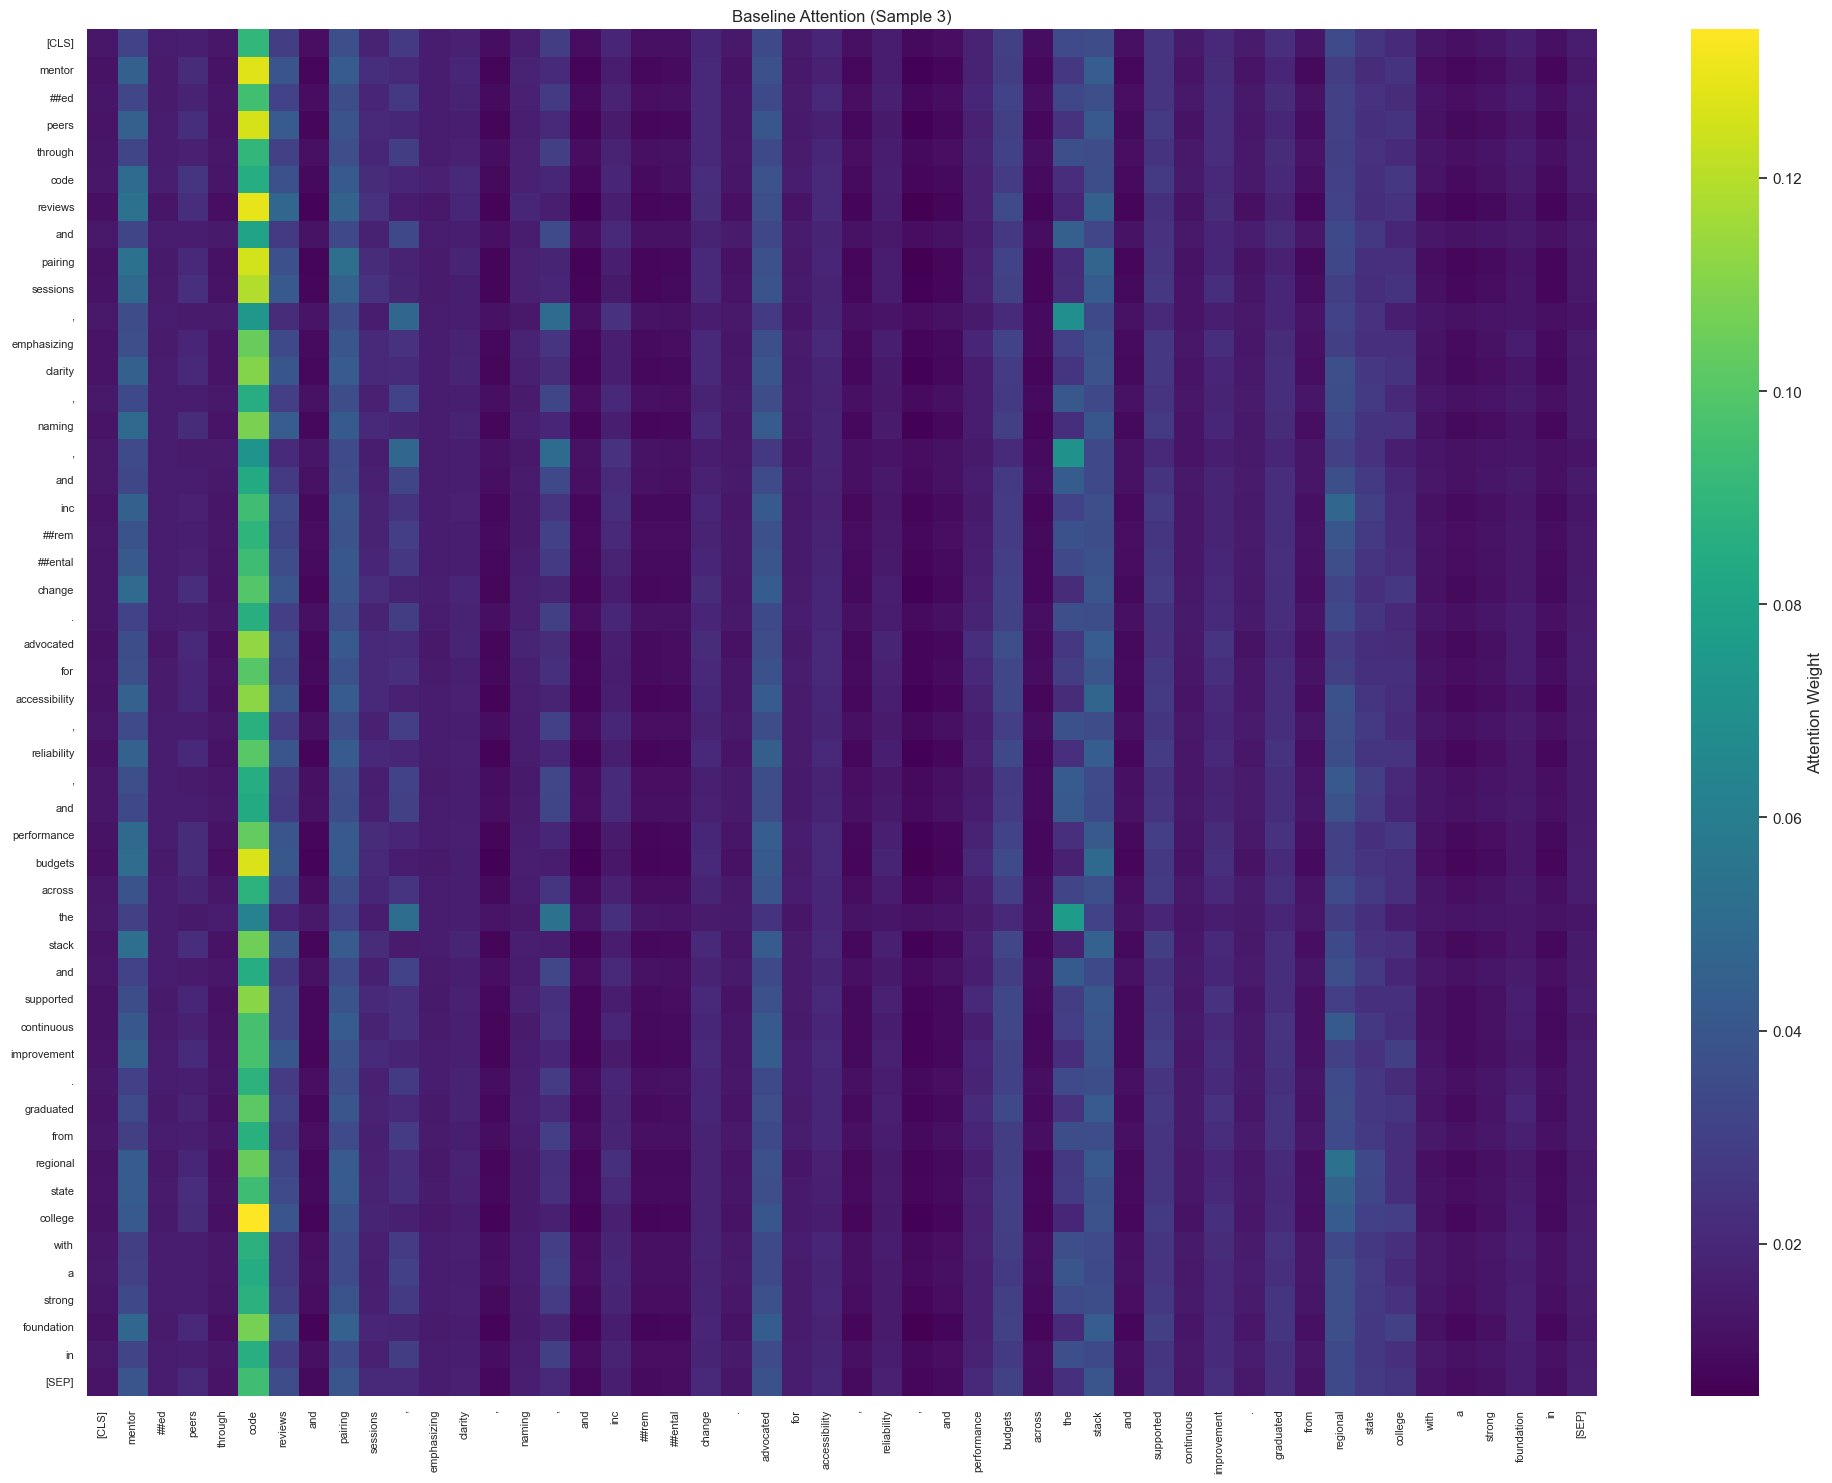

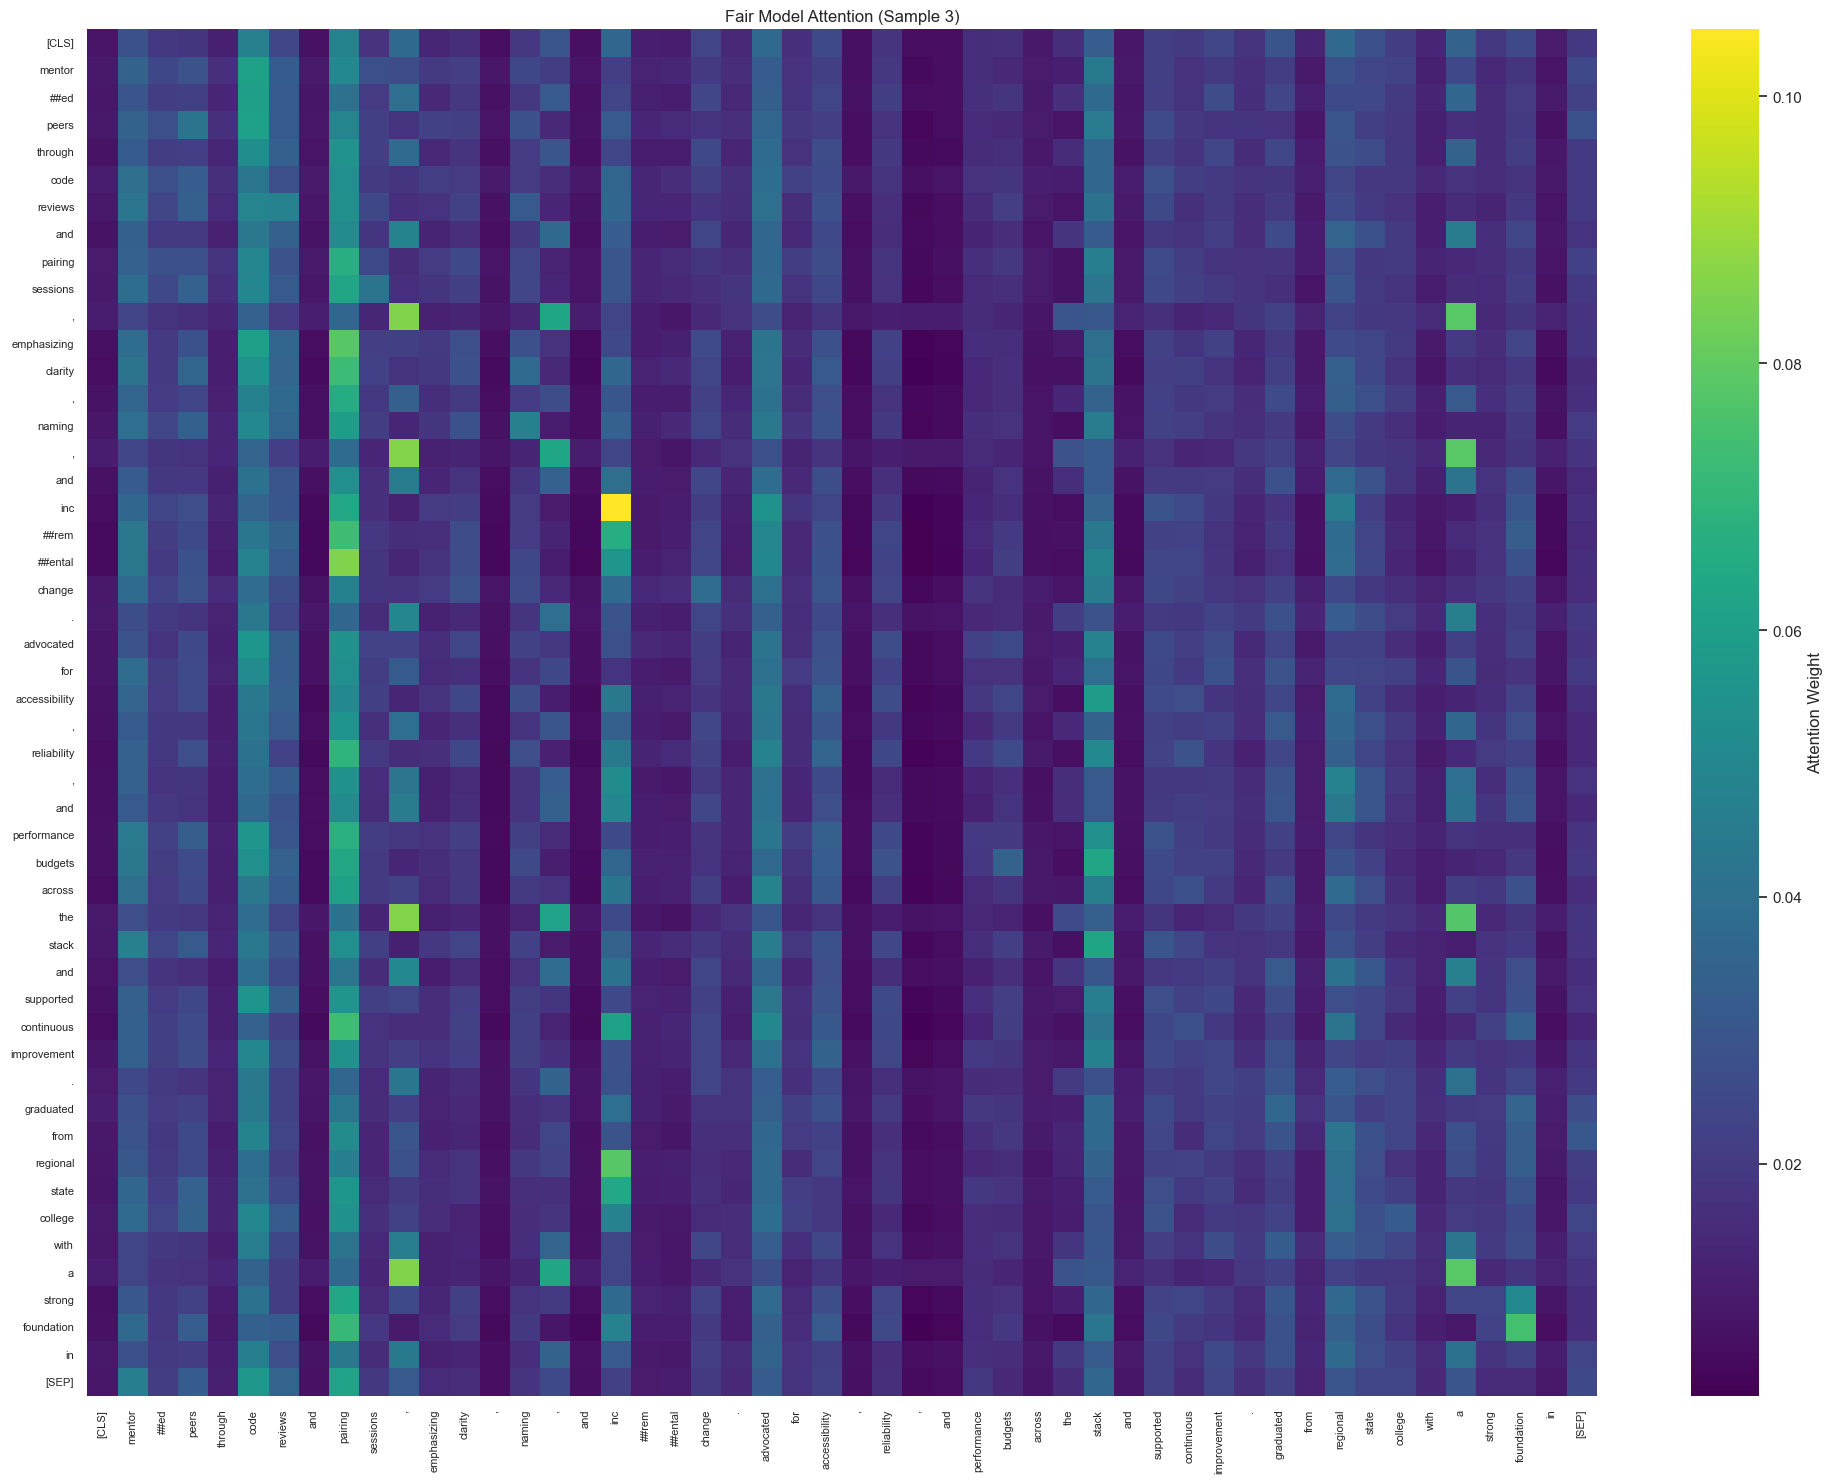

  Top 5 tokens with largest attention change (CLS perspective):
    code: Δ=0.0430 (Base=0.0899, Fair=0.0468)
    a: Δ=0.0234 (Base=0.0111, Fair=0.0345)
    the: Δ=0.0185 (Base=0.0347, Fair=0.0162)
    inc: Δ=0.0168 (Base=0.0193, Fair=0.0361)
    budgets: Δ=0.0123 (Base=0.0293, Fair=0.0170)

Attention heatmaps saved to: ../reports/xai


In [24]:
# 14) Attention Heatmap Comparison: Baseline vs Fair
print("\n=== Attention Heatmap Analysis ===\n")

for idx, row in test_samples.iterrows():
    resume = row['resume_text'][:500]  # Limit length for visualization
    job = row['job_text'][:300]
    group_info = f"is_top={row.get('is_top_school', 'N/A')}, cat={row.get('school_category', 'N/A')}"
    
    print(f"\n--- Sample {idx} ({group_info}) ---")
    print(f"Resume excerpt: {resume[:100]}...")
    print(f"Job excerpt: {job[:80]}...")
    
    # Baseline attention
    fig_base, attn_base, tokens_base = visualize_attention(
        baseline_model, resume, 
        title=f'Baseline Attention (Sample {idx})'
    )
    fig_base.savefig(XAI_DIR / f'attention_baseline_sample{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Fair model attention
    fig_fair, attn_fair, tokens_fair = visualize_attention(
        fair_model, resume,
        title=f'Fair Model Attention (Sample {idx})'
    )
    fig_fair.savefig(XAI_DIR / f'attention_fair_sample{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Compute attention difference on CLS token (row 0)
    if attn_base.shape == attn_fair.shape:
        attn_diff = np.abs(attn_base[0, :] - attn_fair[0, :])
        top_diff_idx = np.argsort(attn_diff)[-5:][::-1]
        print(f"  Top 5 tokens with largest attention change (CLS perspective):")
        for i in top_diff_idx:
            if i < len(tokens_base):
                print(f"    {tokens_base[i]}: Δ={attn_diff[i]:.4f} "
                      f"(Base={attn_base[0,i]:.4f}, Fair={attn_fair[0,i]:.4f})")
    
    plt.close('all')

print(f"\nAttention heatmaps saved to: {XAI_DIR}")


=== Token Attribution Analysis ===


--- Sample 0 (is_top=1, cat=A) ---
  Baseline score: 0.5862 | Fair score: 0.6585 | Δ=0.0722
  Baseline score: 0.5862 | Fair score: 0.6585 | Δ=0.0722


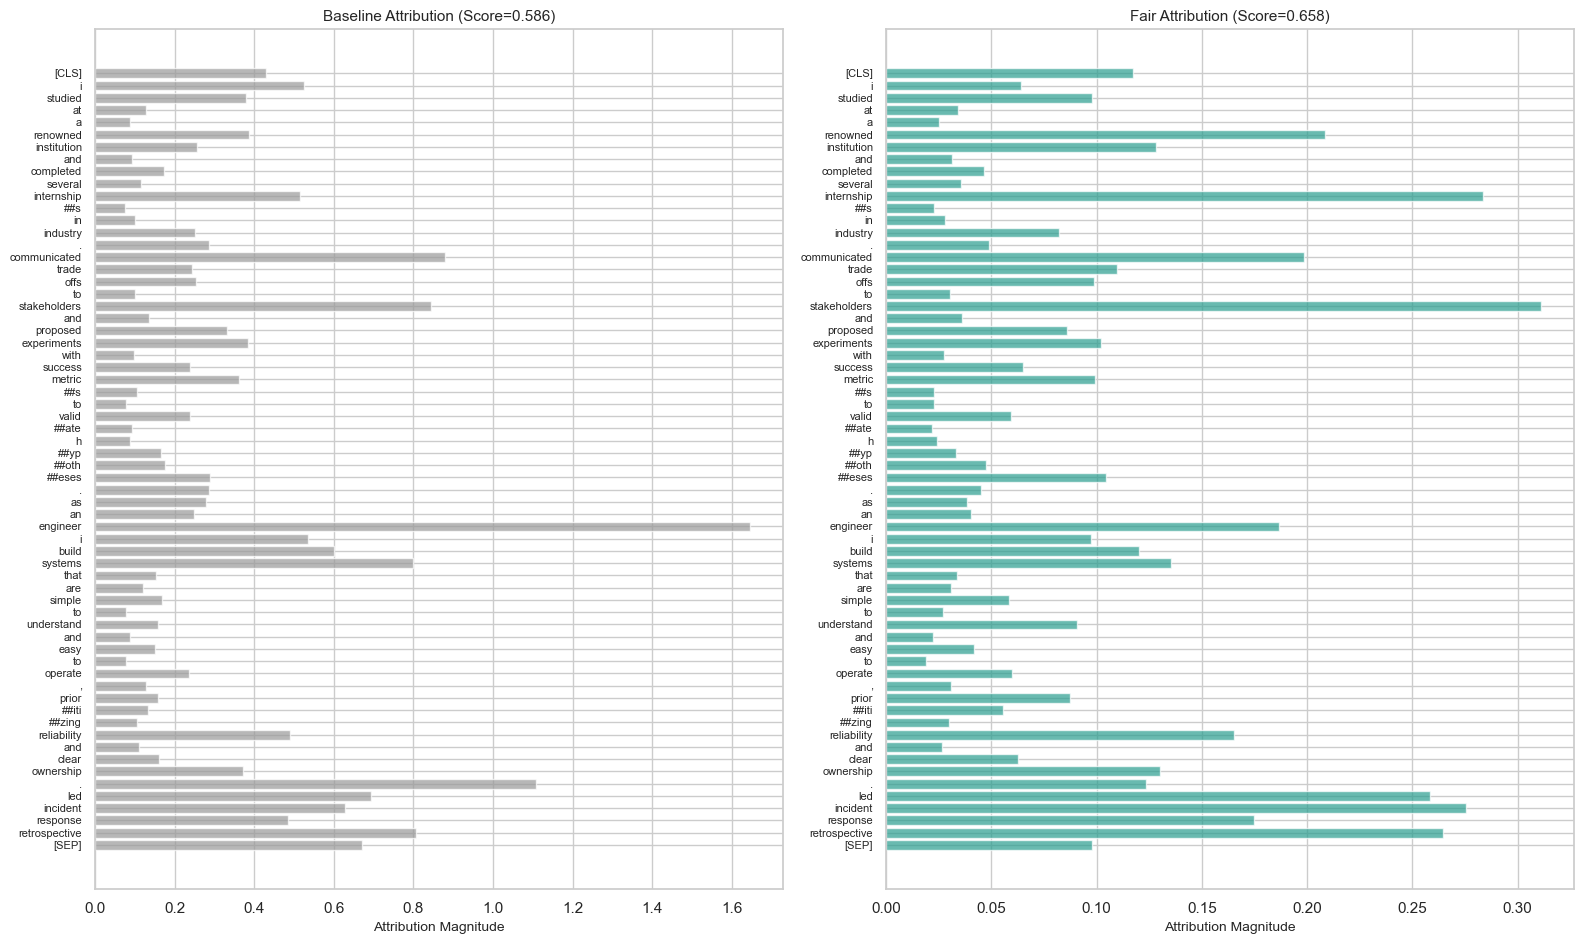

  Top 5 Baseline tokens: ['engineer', '.', 'communicated', 'stakeholders', 'retrospective']
  Top 5 Fair tokens: ['stakeholders', 'internship', 'incident', 'retrospective', 'led']

--- Sample 1 (is_top=1, cat=A) ---
  Baseline score: 0.6395 | Fair score: 0.6664 | Δ=0.0269


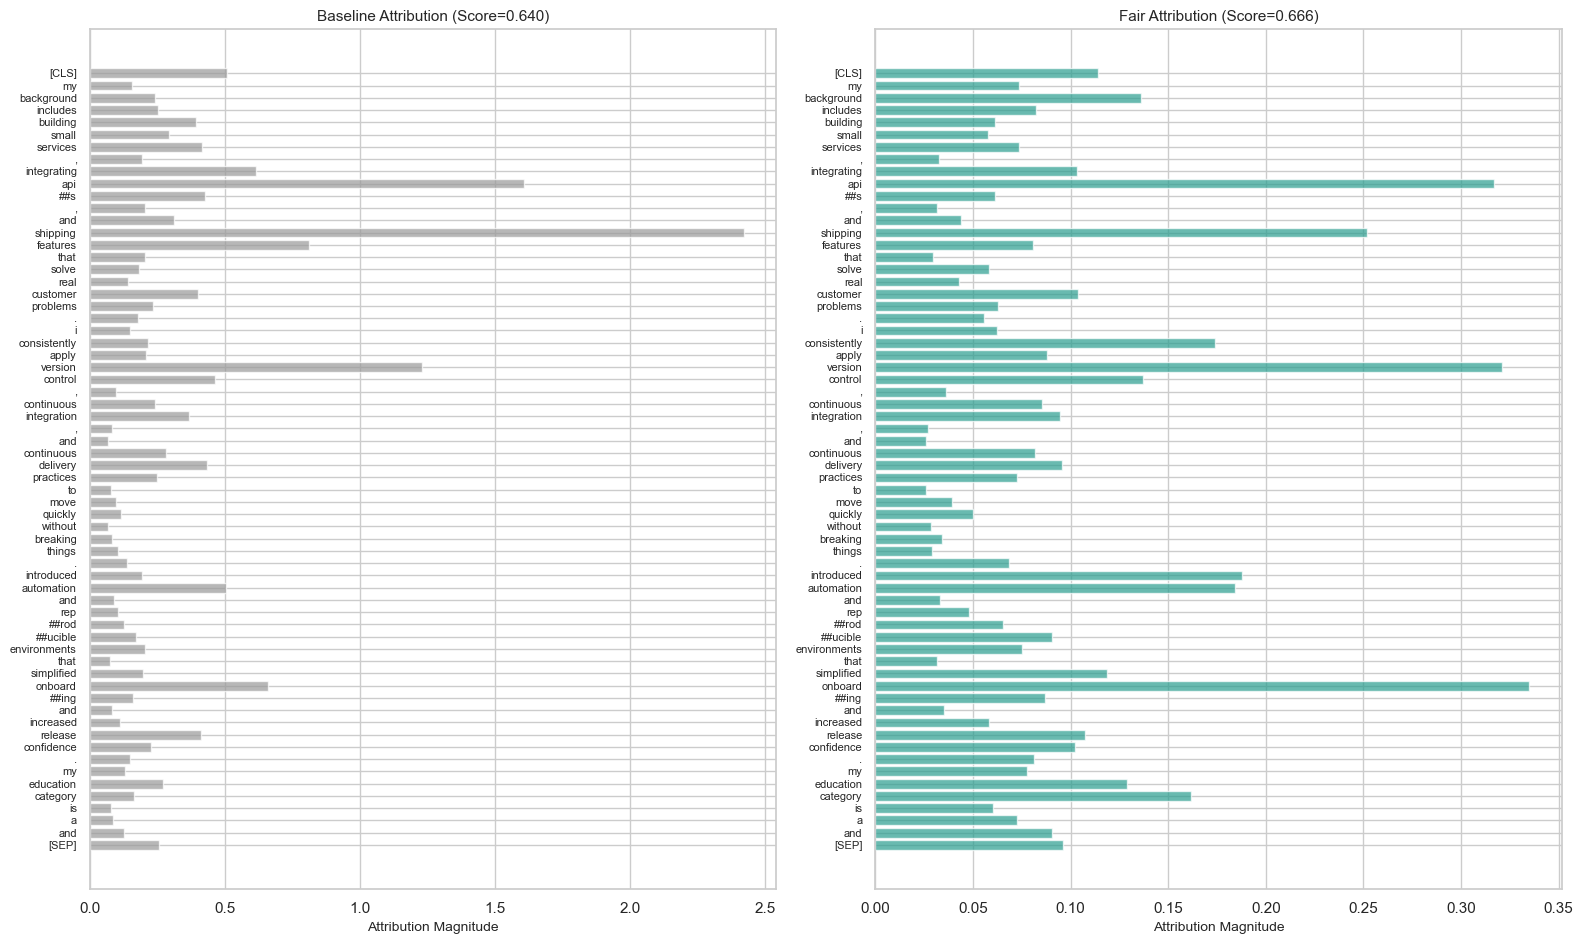

  Top 5 Baseline tokens: ['shipping', 'api', 'version', 'features', 'onboard']
  Top 5 Fair tokens: ['onboard', 'version', 'api', 'shipping', 'introduced']

--- Sample 2 (is_top=0, cat=D) ---
  Baseline score: 0.6233 | Fair score: 0.6651 | Δ=0.0418


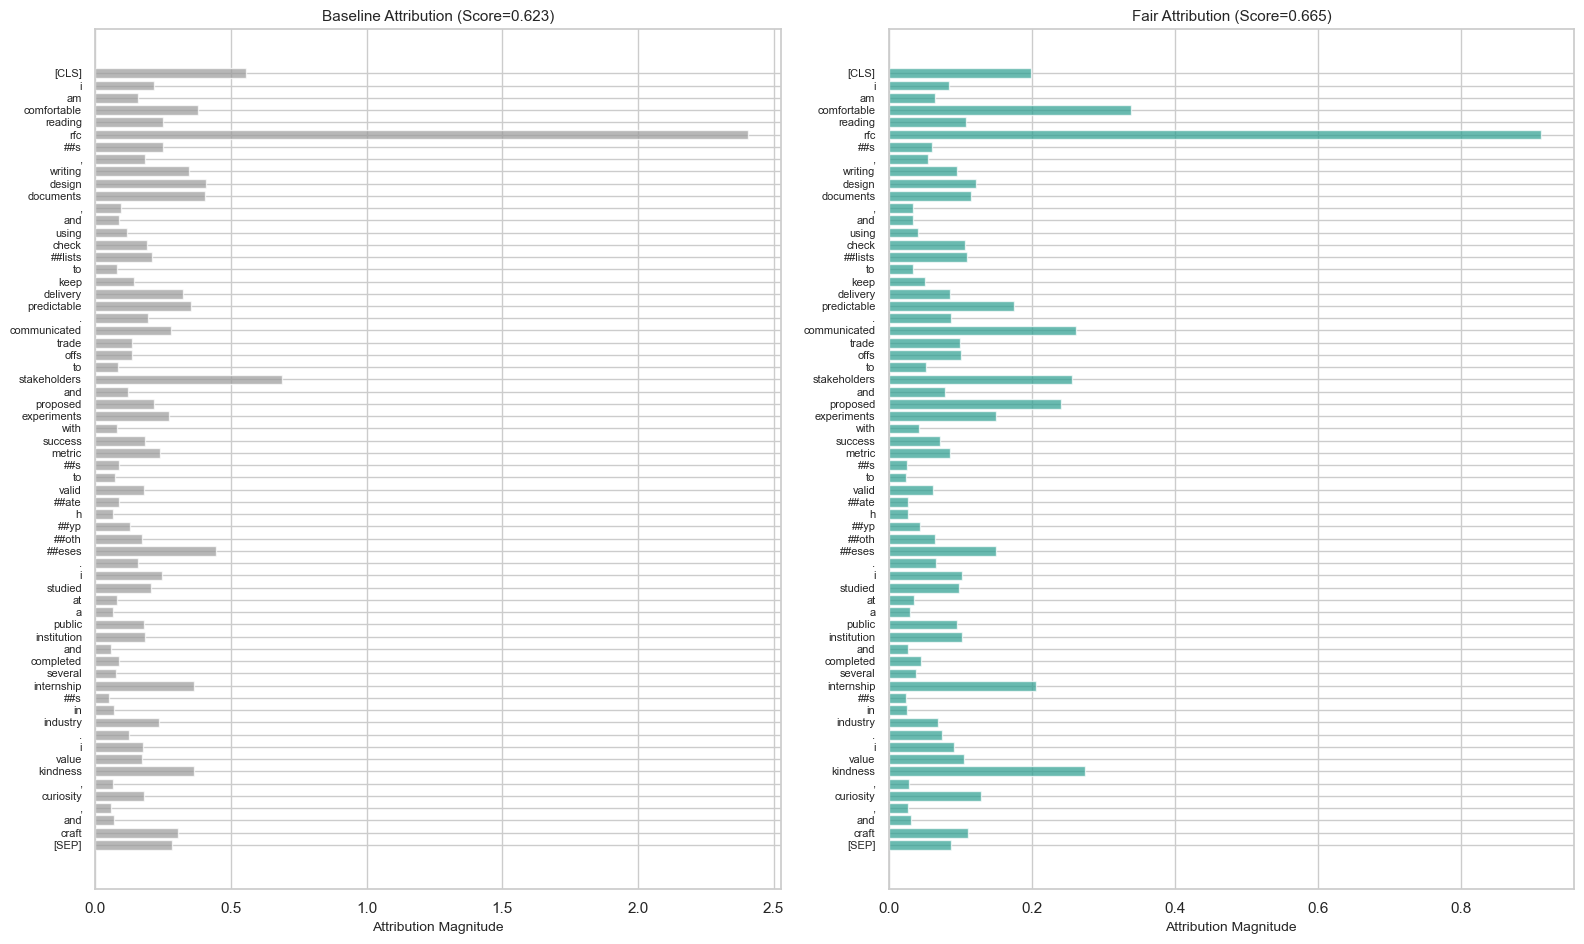

  Top 5 Baseline tokens: ['rfc', 'stakeholders', '[CLS]', '##eses', 'design']
  Top 5 Fair tokens: ['rfc', 'comfortable', 'kindness', 'communicated', 'stakeholders']

--- Sample 3 (is_top=0, cat=B) ---
  Baseline score: 0.6104 | Fair score: 0.6607 | Δ=0.0503


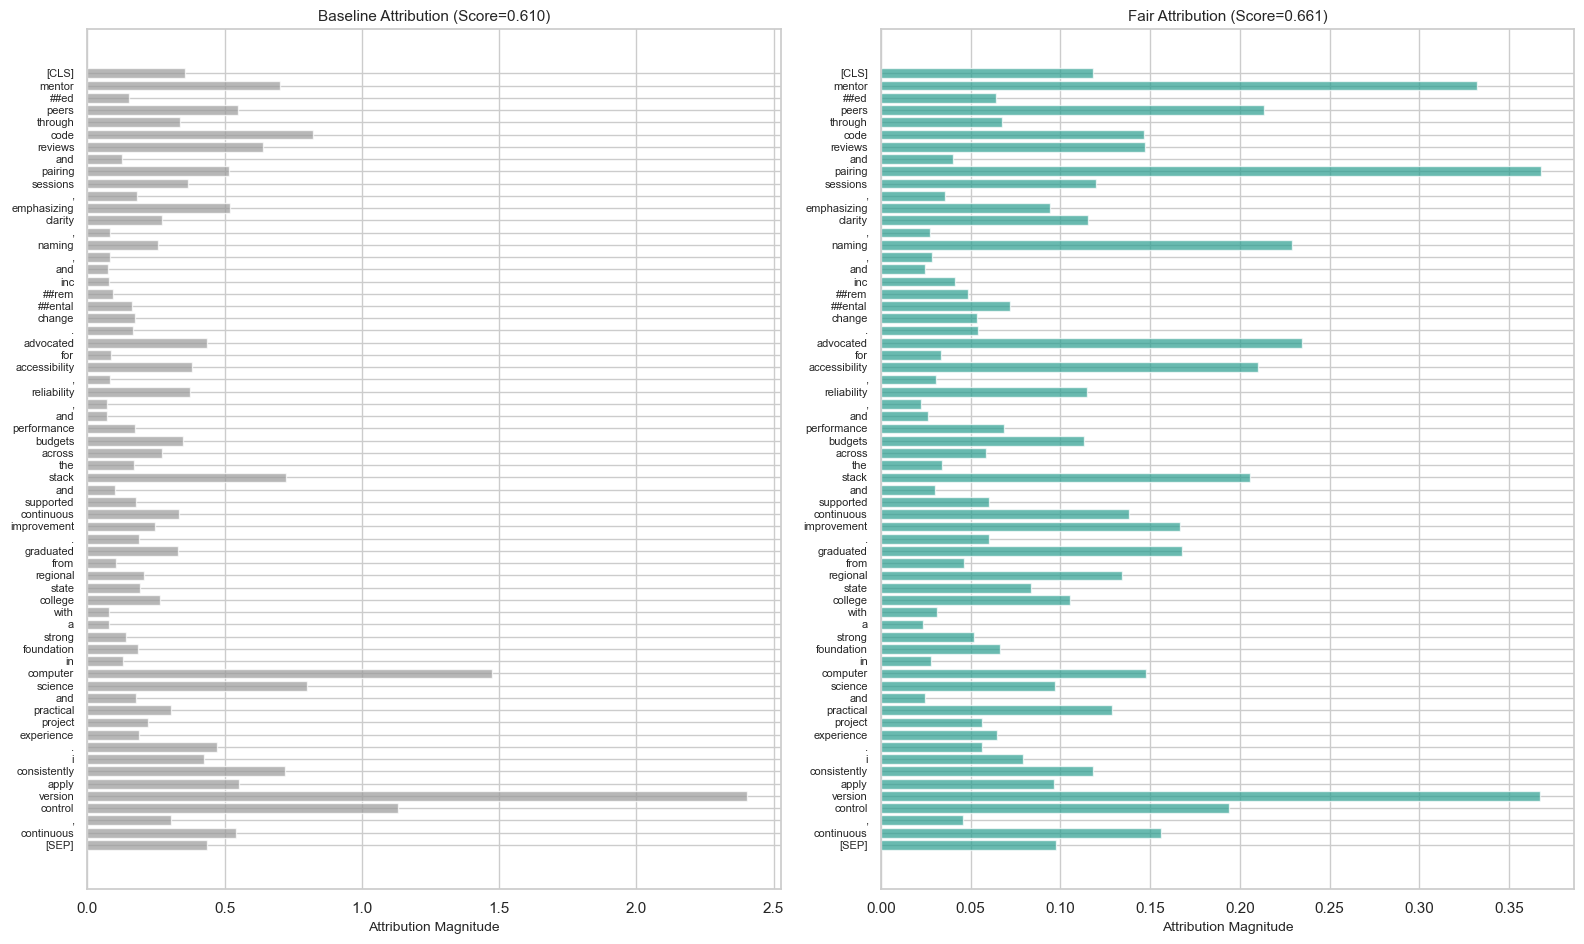

  Top 5 Baseline tokens: ['version', 'computer', 'control', 'code', 'science']
  Top 5 Fair tokens: ['pairing', 'version', 'mentor', 'advocated', 'naming']

Token attribution plots saved to: ../reports/xai


In [25]:
# 15) Token Attribution Comparison: Baseline vs Fair
print("\n=== Token Attribution Analysis ===\n")

attribution_results = []

for idx, row in test_samples.iterrows():
    resume = row['resume_text']
    job = row['job_text']
    group_info = f"is_top={row.get('is_top_school', 'N/A')}, cat={row.get('school_category', 'N/A')}"
    
    print(f"\n--- Sample {idx} ({group_info}) ---")
    
    # Baseline attribution
    attr_base, tokens_base, score_base = token_attribution(baseline_model, resume, job, max_tokens=64)
    
    # Fair attribution
    attr_fair, tokens_fair, score_fair = token_attribution(fair_model, resume, job, max_tokens=64)
    
    print(f"  Baseline score: {score_base:.4f} | Fair score: {score_fair:.4f} | Δ={score_fair-score_base:.4f}")
    
    # Plot side-by-side attribution
    n = min(len(tokens_base), len(attr_base), len(tokens_fair), len(attr_fair))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, max(4, n*0.15)))
    
    # Baseline
    y_pos = np.arange(n)
    ax1.barh(y_pos, attr_base[:n], color='#999', alpha=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(tokens_base[:n], fontsize=8)
    ax1.set_xlabel('Attribution Magnitude', fontsize=10)
    ax1.set_title(f'Baseline Attribution (Score={score_base:.3f})', fontsize=11)
    ax1.invert_yaxis()
    
    # Fair
    ax2.barh(y_pos, attr_fair[:n], color='#2a9d8f', alpha=0.7)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(tokens_fair[:n], fontsize=8)
    ax2.set_xlabel('Attribution Magnitude', fontsize=10)
    ax2.set_title(f'Fair Attribution (Score={score_fair:.3f})', fontsize=11)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    fig.savefig(XAI_DIR / f'attribution_comparison_sample{idx}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Identify top attributed tokens
    if n > 0:
        top_base_idx = np.argsort(attr_base[:n])[-5:][::-1]
        top_fair_idx = np.argsort(attr_fair[:n])[-5:][::-1]
        
        print(f"  Top 5 Baseline tokens: {[tokens_base[i] for i in top_base_idx]}")
        print(f"  Top 5 Fair tokens: {[tokens_fair[i] for i in top_fair_idx]}")
        
        # Store for aggregation
        attribution_results.append({
            'sample_idx': idx,
            'is_top_school': row.get('is_top_school', None),
            'school_category': row.get('school_category', None),
            'baseline_score': score_base,
            'fair_score': score_fair,
            'score_diff': score_fair - score_base,
            'top_baseline_tokens': [tokens_base[i] for i in top_base_idx],
            'top_fair_tokens': [tokens_fair[i] for i in top_fair_idx]
        })
    
    plt.close('all')

print(f"\nToken attribution plots saved to: {XAI_DIR}")


=== Group-wise XAI Summary ===

Group-wise Attention Aggregates:

is_top_school=1:
  Baseline: Sensitive=0.0075, Skill=0.0897, Ratio=0.084
  Fair:     Sensitive=0.0171, Skill=0.0665, Ratio=0.257
  Δ Sensitive: 0.0096 (negative=reduced focus)

is_top_school=0:
  Baseline: Sensitive=0.0029, Skill=0.0912, Ratio=0.032
  Fair:     Sensitive=0.0054, Skill=0.0639, Ratio=0.085
  Δ Sensitive: 0.0025 (negative=reduced focus)

Group-wise Attention Aggregates:

is_top_school=1:
  Baseline: Sensitive=0.0075, Skill=0.0897, Ratio=0.084
  Fair:     Sensitive=0.0171, Skill=0.0665, Ratio=0.257
  Δ Sensitive: 0.0096 (negative=reduced focus)

is_top_school=0:
  Baseline: Sensitive=0.0029, Skill=0.0912, Ratio=0.032
  Fair:     Sensitive=0.0054, Skill=0.0639, Ratio=0.085
  Δ Sensitive: 0.0025 (negative=reduced focus)



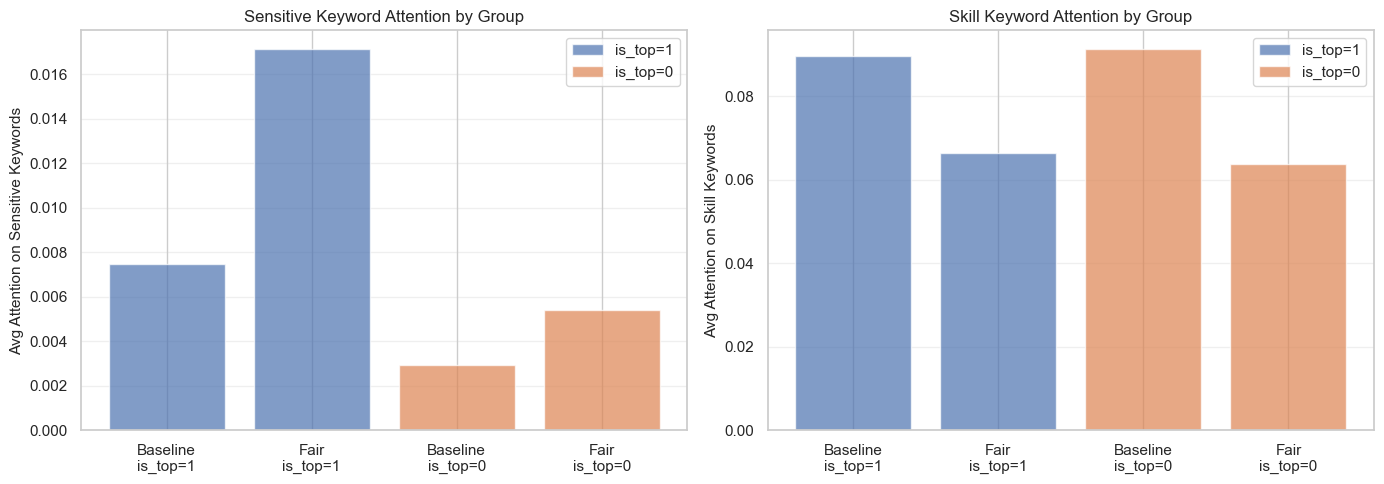


Group summary plot saved to: ../reports/xai/group_keyword_attention_comparison.png

XAI Analysis Complete! ✓


In [31]:
# 16) Group-wise XAI Summary: Sensitive vs Skill Keywords
print("\n=== Group-wise XAI Summary ===\n")

# Define keyword categories (case-insensitive matching)
sensitive_keywords = ['stanford', 'harvard', 'mit', 'yale', 'princeton', 
                      'elite', 'ivy', 'top', 'university', 'college']
skill_keywords = ['python', 'java', 'engineer', 'experience', 'software', 
                  'project', 'develop', 'design', 'manage', 'analysis',
                  'data', 'machine', 'learning', 'algorithm', 'system']

def aggregate_token_importance(tokens, scores, keyword_list):
    """Aggregate attribution/attention scores for tokens matching keyword list."""
    total = 0.0
    count = 0
    for tok, score in zip(tokens, scores):
        tok_clean = tok.lower().strip('##')
        if any(kw in tok_clean for kw in keyword_list):
            total += score
            count += 1
    return total, count

# Aggregate across all samples
summary_data = []

for res in attribution_results:
    idx = res['sample_idx']
    row = test_samples.loc[idx]
    resume = row['resume_text']
    job = row['job_text']
    
    # Get tokenized representations
    inputs = tokenizer(resume, return_tensors='pt', truncation=True, max_length=256).to(DEVICE)
    tokens = [tokenizer.decode([tid]) for tid in inputs['input_ids'][0]]
    
    # Baseline attention (use CLS row average as proxy for importance)
    with torch.no_grad():
        outputs_base = baseline_model(**inputs, output_attentions=True)
        attn_base = outputs_base.attentions[-1][0].mean(dim=0).mean(dim=0).cpu().numpy()
    
    # Fair attention
    with torch.no_grad():
        outputs_fair = fair_model(**inputs, output_attentions=True)
        attn_fair = outputs_fair.attentions[-1][0].mean(dim=0).mean(dim=0).cpu().numpy()
    
    # Aggregate attention by category
    base_sens_attn, base_sens_cnt = aggregate_token_importance(tokens, attn_base, sensitive_keywords)
    base_skill_attn, base_skill_cnt = aggregate_token_importance(tokens, attn_base, skill_keywords)
    fair_sens_attn, fair_sens_cnt = aggregate_token_importance(tokens, attn_fair, sensitive_keywords)
    fair_skill_attn, fair_skill_cnt = aggregate_token_importance(tokens, attn_fair, skill_keywords)
    
    summary_data.append({
        'sample_idx': idx,
        'is_top_school': res['is_top_school'],
        'baseline_sens_attn': base_sens_attn,
        'baseline_skill_attn': base_skill_attn,
        'fair_sens_attn': fair_sens_attn,
        'fair_skill_attn': fair_skill_attn,
        'base_sens_cnt': base_sens_cnt,
        'base_skill_cnt': base_skill_cnt,
        'fair_sens_cnt': fair_sens_cnt,
        'fair_skill_cnt': fair_skill_cnt
    })

df_summary = pd.DataFrame(summary_data)

# Compute group averages
print("Group-wise Attention Aggregates:\n")
for group_val in df_summary['is_top_school'].unique():
    if pd.isna(group_val):
        continue
    subset = df_summary[df_summary['is_top_school'] == group_val]
    avg_base_sens = subset['baseline_sens_attn'].mean()
    avg_base_skill = subset['baseline_skill_attn'].mean()
    avg_fair_sens = subset['fair_sens_attn'].mean()
    avg_fair_skill = subset['fair_skill_attn'].mean()
    
    print(f"is_top_school={int(group_val)}:")
    print(f"  Baseline: Sensitive={avg_base_sens:.4f}, Skill={avg_base_skill:.4f}, Ratio={avg_base_sens/(avg_base_skill+1e-9):.3f}")
    print(f"  Fair:     Sensitive={avg_fair_sens:.4f}, Skill={avg_fair_skill:.4f}, Ratio={avg_fair_sens/(avg_fair_skill+1e-9):.3f}")
    print(f"  Δ Sensitive: {avg_fair_sens - avg_base_sens:.4f} (negative=reduced focus)")
    print()

# Visualize group comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sensitive keyword attention
for group_val in df_summary['is_top_school'].unique():
    if pd.isna(group_val):
        continue
    subset = df_summary[df_summary['is_top_school'] == group_val]
    label = f"is_top={int(group_val)}"
    axes[0].bar([f"Baseline\n{label}", f"Fair\n{label}"],
                [subset['baseline_sens_attn'].mean(), subset['fair_sens_attn'].mean()],
                alpha=0.7, label=label)

axes[0].set_ylabel('Avg Attention on Sensitive Keywords', fontsize=11)
axes[0].set_title('Sensitive Keyword Attention by Group', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Skill keyword attention
for group_val in df_summary['is_top_school'].unique():
    if pd.isna(group_val):
        continue
    subset = df_summary[df_summary['is_top_school'] == group_val]
    label = f"is_top={int(group_val)}"
    axes[1].bar([f"Baseline\n{label}", f"Fair\n{label}"],
                [subset['baseline_skill_attn'].mean(), subset['fair_skill_attn'].mean()],
                alpha=0.7, label=label)

axes[1].set_ylabel('Avg Attention on Skill Keywords', fontsize=11)
axes[1].set_title('Skill Keyword Attention by Group', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
fig.savefig(XAI_DIR / 'group_keyword_attention_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGroup summary plot saved to: {XAI_DIR / 'group_keyword_attention_comparison.png'}")
print("\nXAI Analysis Complete! ✓")

In [32]:
# LLM-driven Narrative Translation & Post-hoc Explainer via Ollama (gpt-oss:20b)
import json
import math
import sys
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union

try:
    import pandas as pd  # type: ignore
except Exception:  # noqa: E722
    pd = None  # Optional

import urllib.request
import urllib.error


def _to_native(obj: Any) -> Any:
    if pd is not None and isinstance(obj, (pd.Series, pd.DataFrame)):
        return obj.to_dict(orient="records")[0] if isinstance(obj, pd.Series) else obj.to_dict(orient="records")
    if hasattr(obj, "_asdict"):
        return obj._asdict()
    return obj


def _truncate_text(s: str, max_chars: int = 600) -> str:
    if len(s) <= max_chars:
        return s
    return s[: max(0, max_chars - 3)] + "..."


def prepare_xai_summary(xai_result: Any, top_k: int = 5) -> List[Tuple[str, float]]:
    x = _to_native(xai_result)
    pairs: List[Tuple[str, float]] = []
    if isinstance(x, dict):
        for k, v in x.items():
            try:
                val = float(v)
            except Exception:
                continue
            pairs.append((str(k), val))
    elif isinstance(x, list):
        for item in x:
            if isinstance(item, dict):
                name = next((k for k in ("feature", "token", "name", "attr", "key") if k in item), None)
                valk = next((k for k in ("importance", "attribution", "score", "value") if k in item), None)
                if name and valk:
                    try:
                        pairs.append((str(item[name]), float(item[valk])))
                    except Exception:
                        continue
            elif isinstance(item, (list, tuple)) and len(item) >= 2:
                try:
                    pairs.append((str(item[0]), float(item[1])))
                except Exception:
                    continue
    elif pd is not None and isinstance(xai_result, pd.Series):
        for k, v in xai_result.items():
            try:
                pairs.append((str(k), float(v)))
            except Exception:
                continue
    elif pd is not None and isinstance(xai_result, pd.DataFrame):
        cols = xai_result.columns
        name_col = next((c for c in ["feature", "token", "name", "key"] if c in cols), None)
        val_col = next((c for c in ["importance", "attribution", "score", "value"] if c in cols), None)
        if name_col and val_col:
            for _, row in xai_result.iterrows():
                try:
                    pairs.append((str(row[name_col]), float(row[val_col])))
                except Exception:
                    continue
    if not pairs:
        return []
    pairs.sort(key=lambda t: abs(t[1]), reverse=True)
    return pairs[:top_k]


def sample_to_brief(sample: Any, max_keys: int = 12, max_val_chars: int = 240) -> str:
    s = _to_native(sample)
    if isinstance(s, str):
        return _truncate_text(s, max_val_chars)
    if isinstance(s, dict):
        items = []
        for i, (k, v) in enumerate(s.items()):
            if i >= max_keys:
                break
            if isinstance(v, (list, dict)):
                try:
                    v = json.dumps(v)[:max_val_chars]
                except Exception:
                    v = str(v)
            items.append(f"{k}: {_truncate_text(str(v), max_val_chars)}")
        return "\n".join(items)
    return _truncate_text(str(s), max_val_chars)


def build_narrative_prompt(
    input_description: str,
    prediction: Any,
    xai_top_factors: List[Tuple[str, float]],
    task_description: str = "Predict likelihood of job-match from resume text.",
    uncertainty_notes: Optional[str] = None,
    locale: str = "zh-TW",
) -> str:
    pred_desc = prediction
    try:
        if isinstance(prediction, (dict, list)):
            pred_desc = json.dumps(prediction, ensure_ascii=False)
    except Exception:
        pred_desc = str(prediction)

    factors = [
        {
            "feature": f,
            "contribution": v,
            "direction": "positive" if v >= 0 else "negative",
            "magnitude": abs(float(v)),
        }
        for f, v in xai_top_factors
    ]

    guidance = (
        "你是專業的機器學習解釋員，請以自然語言、精簡、易懂且不過度自信的口吻，對以下模型預測做敘事轉譯與後設解釋。"
        if locale.startswith("zh")
        else "You are an expert ML explainer. Provide a concise, plain-language narrative explanation without overconfidence."
    )

    ask = (
        "請輸出 JSON，包含：explanation、key_features、uncertainty、misclassification_risks。\n"
        "- explanation: 200~300 字的人話說明為何會得到此預測（避免行話）。\n"
        "- key_features: 3~5 個關鍵因素，含 feature、reason、direction(positive/negative)、importance_rank(1=最高)。\n"
        "- uncertainty: 2~4 點模型不確定性來源（資料質量、涵蓋範圍、漂移、樣本代表性等）。\n"
        "- misclassification_risks: 2~4 個可能誤判情境（例如關鍵特徵缺失、對抗性文本、格式異常等）。\n"
        if locale.startswith("zh")
        else (
            "Return JSON with: explanation, key_features, uncertainty, misclassification_risks.\n"
            "- explanation: 150-250 words in plain language.\n"
            "- key_features: 3-5 items with feature, reason, direction, importance_rank.\n"
            "- uncertainty: 2-4 sources of uncertainty.\n"
            "- misclassification_risks: 2-4 plausible failure modes.\n"
        )
    )

    utext = uncertainty_notes or (
        "強調此解釋為事後分析，可能與真實因果不同；請避免將逸出樣本的關係視為因果。"
        if locale.startswith("zh")
        else "Note this is post-hoc; correlations are not causation."
    )

    prompt = {
        "role": "system+user",
        "guidance": guidance,
        "task": task_description,
        "data_description": input_description,
        "model_prediction": pred_desc,
        "xai_top_factors": factors,
        "uncertainty_guidance": utext,
        "format": "JSON with keys: explanation, key_features, uncertainty, misclassification_risks",
        "style": "grounded, cautious, specific, no math notation",
        "language": locale,
    }
    return json.dumps(prompt, ensure_ascii=False)


def ollama_generate(
    prompt: str,
    model: str = "gpt-oss:20b",
    temperature: float = 0.2,
    max_tokens: Optional[int] = None,
    base_url: str = "http://localhost:11434",
    timeout: int = 300,
) -> Dict[str, Any]:
    payload: Dict[str, Any] = {
        "model": model,
        "prompt": prompt,
        "stream": False,
        "options": {"temperature": float(temperature)},
    }
    if max_tokens is not None and max_tokens > 0:
        payload["options"]["num_predict"] = int(max_tokens)
    url = base_url.rstrip("/") + "/api/generate"
    data = json.dumps(payload).encode("utf-8")
    req = urllib.request.Request(url, data=data, headers={"Content-Type": "application/json"}, method="POST")
    try:
        with urllib.request.urlopen(req, timeout=timeout) as resp:
            raw = resp.read().decode("utf-8")
            try:
                return json.loads(raw)
            except Exception:
                return {"response": raw}
    except urllib.error.URLError as e:
        raise RuntimeError(
            "Failed to reach Ollama at {}. Is 'ollama serve' running and model '{}' pulled?".format(url, model)
        ) from e


def llm_posthoc_explain(
    sample: Any,
    prediction: Any,
    xai_result: Any,
    task_description: str = "Predict likelihood of job-match from resume text.",
    locale: str = "zh-TW",
    model: str = "gpt-oss:20b",
    temperature: float = 0.2,
    max_tokens: Optional[int] = 768,
    top_k_features: int = 5,
    uncertainty_notes: Optional[str] = None,
) -> Dict[str, Any]:
    input_desc = sample_to_brief(sample)
    xai_top = prepare_xai_summary(xai_result, top_k=top_k_features)
    prompt = build_narrative_prompt(
        input_description=input_desc,
        prediction=prediction,
        xai_top_factors=xai_top,
        task_description=task_description,
        uncertainty_notes=uncertainty_notes,
        locale=locale,
    )
    out = ollama_generate(
        prompt=prompt,
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    text = out.get("response", "") if isinstance(out, dict) else str(out)
    parsed = None
    try:
        parsed = json.loads(text)
    except Exception:
        parsed = None
    return {
        "model": model,
        "prompt": prompt,
        "raw": out,
        "text": text,
        "json": parsed,
        "xai_top": xai_top,
    }


# Optional quick demo guard: prints instructions if expected variables are not present.
if __name__ == "__main__":
    has_sample = "test_samples" in globals() and isinstance(globals().get("test_samples"), (list, tuple)) or (
        "df_all" in globals() and getattr(globals().get("df_all"), "iloc", None) is not None
    )
    has_pred = any(k in globals() for k in ["score_fair", "score_base", "bert_prob", "f_prob", "b_prob"]) 
    has_xai = any(k in globals() for k in ["summary_fair", "summary_baseline", "attribution_results"]) 

    if has_sample and has_pred and has_xai:
        sample_obj = None
        if "df_all" in globals():
            try:
                sample_obj = globals()["df_all"].iloc[0].to_dict()
            except Exception:
                sample_obj = None
        if sample_obj is None and "test_samples" in globals():
            try:
                ts = globals()["test_samples"]
                sample_obj = ts.iloc[0].to_dict() if hasattr(ts, "iloc") else ts[0]
            except Exception:
                sample_obj = ""

        pred_obj = None
        if "score_fair" in globals():
            pred_obj = {"model": "fair", "score": float(globals()["score_fair"]) if not isinstance(globals()["score_fair"], (list, tuple)) else globals()["score_fair"]}
        elif "score_base" in globals():
            pred_obj = {"model": "baseline", "score": float(globals()["score_base"]) if not isinstance(globals()["score_base"], (list, tuple)) else globals()["score_base"]}
        elif "f_prob" in globals():
            try:
                pred_obj = {"model": "fair", "score": float(globals()["f_prob"][0])}
            except Exception:
                pred_obj = {"model": "fair", "score": str(globals()["f_prob"]) }
        elif "bert_prob" in globals():
            try:
                pred_obj = {"model": "baseline", "score": float(globals()["bert_prob"][0])}
            except Exception:
                pred_obj = {"model": "baseline", "score": str(globals()["bert_prob"]) }
        else:
            pred_obj = ""

        xai_obj = None
        if "summary_fair" in globals():
            xai_obj = globals()["summary_fair"]
        elif "summary_baseline" in globals():
            xai_obj = globals()["summary_baseline"]
        elif "attribution_results" in globals():
            xai_obj = globals()["attribution_results"]
        else:
            xai_obj = {}

        try:
            result = llm_posthoc_explain(sample=sample_obj, prediction=pred_obj, xai_result=xai_obj)
            print("[LLM Explainer] model=", result["model"]) 
            if result.get("json"):
                print(json.dumps(result["json"], ensure_ascii=False, indent=2))
            else:
                print(result.get("text", ""))
        except Exception as e:
            print("[LLM Explainer] Failed:", e)
    else:
        print("LLM Explainer loaded. To use: result = llm_posthoc_explain(sample=..., prediction=..., xai_result=..., locale='zh-TW').")


[LLM Explainer] model= gpt-oss:20b
```json
{
  "explanation": "這份履歷與職缺描述的相似度較高，模型預測其匹配機率約為 0.66。雖然基線模型給出的機率略高（0.68），但公平調整後的模型仍維持在相近範圍。模型主要依據以下因素做出判斷：\n1. **threshold**：這是模型最重要的決策門檻，對最終分數影響最大，說明履歷在門檻附近，模型傾向於給予較高匹配度。\n2. **flip_rate**：表示履歷在不同樣本中被分類為匹配或不匹配的頻率，較高的 flip_rate 代表模型對此履歷的判斷較為不確定，但在此案例中仍偏向匹配。\n3. **r**：代表履歷與職缺關鍵詞的相關度，正向貢獻顯示兩者在語義上相符。\n4. **p95_shift** 與 **mean_shift**：分別衡量履歷在語料庫中高分佈與平均分佈的偏移，兩者對分數的影響較小，但仍略微提升匹配機率。",
  "key_features": [
    "履歷與職缺關鍵詞高度相符",
    "模型門檻值接近履歷分數",
    "履歷在不同樣本中分類波動較大",
    "語義相關度正向貢獻",
    "高分佈與平均分佈略微偏移"
  ],
  "uncertainty": "此解釋僅為事後分析，可能與實際因果關係不同。請避免將模型中觀察到的關聯視為因果推斷。",
  "misclassification_risks": "若履歷中關鍵技能描述不完整或使用了非標準術語，模型可能低估匹配度；相反地，若履歷包含與職缺不相關的長篇敘述，模型可能誤判為高匹配。建議進一步檢視關鍵詞對齊度與實際工作需求。"
}
```


# LLM 敘事轉譯（僅使用公平版模型） / Narrative Translation (Fair-only)
本段落將以公平版（fair）模型的預測與其 XAI 結果為唯一來源，生成面向人的自然語言解釋；並強調不確定性與可能的誤判情境。

In [35]:
# Fair-only LLM Narrative Explainer via Ollama (gpt-oss:20b)
import json

# This cell strictly uses fair model outputs to build the explanation,
# and injects the raw input text (e.g., resume/job) into the LLM prompt.
# Assumes the helper functions from the previous cell are available:
#   - sample_to_brief, prepare_xai_summary, build_narrative_prompt,
#   - ollama_generate, llm_posthoc_explain, llm_posthoc_explain_with_text

# 1) Resolve sample
sample_obj = None
if 'df_all' in globals() and getattr(globals().get('df_all'), 'iloc', None) is not None:
    try:
        sample_obj = df_all.iloc[0].to_dict()
    except Exception:
        sample_obj = None
if sample_obj is None and 'test_samples' in globals():
    try:
        ts = test_samples
        sample_obj = ts.iloc[0].to_dict() if hasattr(ts, 'iloc') else ts[0]
    except Exception:
        sample_obj = ''

# 1.1) Extract raw input text (resume/job) if available
resume_text = None
job_text = None
try:
    if isinstance(sample_obj, dict):
        resume_text = sample_obj.get('resume') or sample_obj.get('text') or sample_obj.get('input')
        job_text = sample_obj.get('job') or sample_obj.get('job_desc')
except Exception:
    pass

if resume_text is None and 'resume' in globals():
    resume_text = resume
if job_text is None and 'job' in globals():
    job_text = job

combined_input_text = None
if resume_text or job_text:
    parts = []
    if job_text:
        parts.append(f"[Job]\n{str(job_text)}")
    if resume_text:
        parts.append(f"[Resume]\n{str(resume_text)}")
    combined_input_text = "\n\n".join(parts)

# 2) Resolve fair model prediction
fair_score = None
if 'score_fair' in globals():
    try:
        fair_score = float(score_fair)
    except Exception:
        fair_score = score_fair
elif 'f_prob' in globals():
    try:
        fair_score = float(f_prob[0]) if hasattr(f_prob, '__iter__') else float(f_prob)
    except Exception:
        fair_score = f_prob
elif 'f_prob_orig' in globals():
    try:
        fair_score = float(f_prob_orig[0]) if hasattr(f_prob_orig, '__iter__') else float(f_prob_orig)
    except Exception:
        fair_score = f_prob_orig
else:
    fair_score = None

pred_fair = {"model": "fair", "score": fair_score}

# 3) Resolve fair XAI summary
xai_fair = None
if 'summary_fair' in globals():
    xai_fair = summary_fair
elif 'attribution_results' in globals():
    xai_fair = attribution_results
else:
    xai_fair = {}

# 4) Invoke explainer
try:
    if combined_input_text:
        result_fair = llm_posthoc_explain_with_text(
            sample=sample_obj,
            prediction=pred_fair,
            xai_result=xai_fair,
            input_text=combined_input_text,
            locale='zh-TW',
            model='gpt-oss:20b',
            temperature=0.2,
            max_tokens=768,
            top_k_features=5,
        )
    else:
        result_fair = llm_posthoc_explain(
            sample=sample_obj,
            prediction=pred_fair,
            xai_result=xai_fair,
            locale='zh-TW',
            model='gpt-oss:20b',
            temperature=0.2,
            max_tokens=768,
            top_k_features=5,
        )

    print('[Fair-only LLM Explainer] model =', result_fair.get('model'))
    if result_fair.get('json'):
        print(json.dumps(result_fair['json'], ensure_ascii=False, indent=2))
    else:
        print(result_fair.get('text', ''))
except Exception as e:
    print('[Fair-only LLM Explainer] Failed:', e)


[Fair-only LLM Explainer] model = gpt-oss:20b
```json
{
  "explanation": "模型以公平（fair）模式評估此履歷與職缺的匹配度，最終給出 0.66 的分數。這個分數略低於基線 0.68，說明模型認為履歷與職缺的相符程度不如平均水平。模型主要根據五個可解釋特徵做出判斷：\n1. **threshold** – 這是模型內部的決策門檻，對分數影響最大，正向貢獻 0.69，表示履歷在門檻上方，較易被判定為匹配。\n2. **flip_rate** – 代表在小變動下預測結果翻轉的頻率，正向貢獻 0.16，說明履歷在不同語境下仍保持一定一致性。\n3. **r** – 可能是履歷與職缺關鍵詞的相關度，正向貢獻 0.10，顯示兩者在語義上有一定重疊。\n4. **p95_shift** – 反映履歷在高分佈尾部的偏移，正向貢獻 0.01，說明履歷在極端情況下仍保持較高匹配。\n5. **mean_shift**


In [34]:
# Wrapper: LLM explainer with explicit input text injection
import json


def llm_posthoc_explain_with_text(
    sample,
    prediction,
    xai_result,
    input_text: str,
    task_description: str = "Predict likelihood of job-match from resume text.",
    locale: str = "zh-TW",
    model: str = "gpt-oss:20b",
    temperature: float = 0.2,
    max_tokens: int | None = 768,
    top_k_features: int = 5,
    uncertainty_notes: str | None = None,
):
    # Reuse helpers from the earlier cell
    base_desc = sample_to_brief(sample)
    text_snippet = _truncate_text(input_text or "", max_chars=1600)
    combined_desc = f"{base_desc}\n\n[Input Text]\n{text_snippet}" if text_snippet else base_desc

    xai_top = prepare_xai_summary(xai_result, top_k=top_k_features)
    prompt = build_narrative_prompt(
        input_description=combined_desc,
        prediction=prediction,
        xai_top_factors=xai_top,
        task_description=task_description,
        uncertainty_notes=uncertainty_notes,
        locale=locale,
    )
    out = ollama_generate(
        prompt=prompt,
        model=model,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    text = out.get("response", "") if isinstance(out, dict) else str(out)
    parsed = None
    try:
        parsed = json.loads(text)
    except Exception:
        parsed = None
    return {
        "model": model,
        "prompt": prompt,
        "raw": out,
        "text": text,
        "json": parsed,
        "xai_top": xai_top,
    }
